In [1]:
import numpy as np
import pandas as pd
import os

import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import pyampute
import pickle 
import time
import ast 
from scipy.stats import chi2
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
from scipy import stats
from xgboost import XGBRegressor
from sklearn import tree
from pyampute.ampute import MultivariateAmputation
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from lifelines import CoxPHFitter, WeibullFitter, WeibullAFTFitter
from datetime import datetime, date, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tableone import TableOne 
from os.path import isfile, join
from sklearn.metrics import mean_absolute_error, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.gam.tests.test_penalized import df_autos
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from scipy.spatial import distance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from app_transition_dict import get_transition_dict, get_transition_code
from app_init import get_multi_state_covariates, get_multi_state_cov_quartiles
from app_init import replace_covariate_labels, replace_pvalue, get_variables_cox
import glob
import warnings 
warnings.filterwarnings('ignore')

drive = 'G'
main_path = drive + ':/Shared drives/CKD_Progression/data/CKD_COHORT_Jan2010_Mar2024_v3.csv'
data_path = drive + ':/Shared drives/CKD_Progression/data/'
docs_path = drive + ':/Shared drives/CKD_Progression/docs/'
save_path = drive + ':/Shared drives/CKD_Progression/save/'
resu_path = drive + ':/Shared drives/CKD_Progression/result/'
covariates_path = docs_path + 'covariates.csv'
removecols_path = docs_path + 'remove_columns.csv'

def generate_df_continuous(df, variables, q = 3):
    bins_dict = {} 
    for variable, prefix, column_name in variables:
        df[column_name], bins = pd.qcut(
            df[variable],
            q = q,
            labels = False,
            duplicates = 'drop',
            retbins = True)
        bins_dict[variable] = bins
        dummies = pd.get_dummies(df[column_name], prefix = prefix)
        df = pd.concat([df, dummies], axis = 1)
    return df, bins_dict

def generate_df_continuous_predefined(df, variables, get_columns = False):
    for variable, prefix, column_name, bins, labels in variables:
        df[column_name] = pd.cut(df[variable], bins = bins, labels = labels, right = False)

        if get_columns:
            dummies = pd.get_dummies(df[column_name], prefix = prefix)
            df = pd.concat([df, dummies], axis = 1)
    return df

def get_first_dates():
    heart_failure = pd.read_excel(docs_path + 'HF_FIRSTDATE_2010_2023.xlsx') ['ENC_HN'].unique().tolist()
    hypertension  = pd.read_excel(docs_path + 'HTN_FIRSTDATE_2010_2023.xlsx')['ENC_HN'].unique().tolist()
    diabetes = pd.read_csv(docs_path + 'DM_FIRSTDATE_2010_2023.csv')['ENC_HN'].unique().tolist()
    atrialfb = pd.read_csv(docs_path + 'AF_FIRSTDATE_2010_2023.csv')['ENC_HN'].unique().tolist()
    return heart_failure, hypertension, diabetes, atrialfb

def merge_comorbidity(df, comorbidity, disease_code):
    disease_column = disease_code.upper()
    df[disease_column] = df['ENC_HN'].isin(comorbidity).astype(int)
    return df

def load_dataset(version = '13', get_columns = False):
    covariates, variables = get_multi_state_cov_quartiles(), get_variables_cox()
    order_covariates = pd.read_csv(docs_path + 'cox_covariates.csv')
    model_vars = ['ENC_HN', 'transition', 'fr', 'to', 'status', 'tstart', 'tstops', 'time']
    heart_failure, hypertension, diabetes, atrialfb = get_first_dates()
    
    long_df = pd.read_csv(save_path + 'multi_state_long_ver0' + f'{version}.csv')
    long_df['gender']  = long_df['gender'].replace('M', 1).replace('F', 0)
    long_df['pathway'] = long_df['fr'] + '_to_' + long_df['to']
    long_df = generate_df_continuous_predefined(long_df, variables, get_columns = get_columns)
    long_df['statin']  = long_df[['statinhydro', 'statinlipo']].max(axis = 1)
    long_df['raas']    = long_df[['arb', 'acei']].max(axis = 1)
    long_df = long_df.drop(columns = ['statinhydro', 'statinlipo'])
    long_df = merge_comorbidity(long_df, heart_failure, 'hf')
    long_df = merge_comorbidity(long_df, diabetes,      'dm')
    long_df = merge_comorbidity(long_df, atrialfb,      'af')
    return covariates, order_covariates, long_df

In [53]:
folder_path = r'G:/Shared drives/CKD_Progression/result/univariate/final_21December2024/'
excel_files = [file for file in os.listdir(folder_path) if file.endswith(('.xls', '.xlsx'))]
excel_files = [
    os.path.join(folder_path, file) for file in excel_files 
    if ('CKD' in file or 'CVD' in file or 'DEAD' in file) and not file.startswith('~$')]
excel_files = sorted(excel_files)

RESULTS = []
for file in excel_files:
    name = file.split('/')[-1].split('.')[0].replace('_to_', ' → ')
    data = pd.read_excel(file, sheet_name = 'Sheet1')
    data['Unnamed: 0'] = data['Unnamed: 0'].fillna(method = 'ffill')
    data = data[['Unnamed: 0', 'Unnamed: 2', 'Unnamed: 12', 'Unnamed: 13']]
    data = data[~data['Unnamed: 2'].isin(['No', 'category', 'Female'])]
    data = data[~data['Unnamed: 0'].isin(['Cholesterol', 'Triglyceride', 'FPG', 'HbA1C'])]
    data = data.reset_index(drop = True)
    data['HR (95CI)'] = data['Unnamed: 12'].apply(lambda x: str(np.round(x, 2)) if pd.notnull(x) else '').astype(str) + ' ' + data['Unnamed: 13'].fillna('').astype(str)
    data = data.drop(columns = ['Unnamed: 12', 'Unnamed: 13'])
    data.columns = ['covariates', 'category', name]
    naming = data[['covariates', 'category']].copy()
    data = data[[name]]

    RESULTS.append(data)

RESULTS = pd.concat(RESULTS, axis = 1)
FINAL   = pd.concat([naming, RESULTS], axis = 1)
FINAL.to_excel(r'G:\Shared drives\CKD_Progression\result\multivariate\main_results_21December2024.xlsx', index = False)

In [2]:
covariates, order_covariates, long_df = load_dataset(version = '13', get_columns = False)
unique_transitions = long_df['pathway'].unique().tolist()
# for path in ['CKD3A_to_CKD4', 'CKD3A_to_CKD5A', 'CKD3A_to_CKD5B', 'CKD3B_to_CKD5A', 'CKD3B_to_CKD5B', 'CKD4_to_CKD5B', 'CKD3A_to_DEAD']:
#     unique_transitions.remove(path)

# long_df.drop_duplicates(subset = ['ENC_HN', 'transition'], keep = 'first', inplace = True)

In [13]:
def get_baseline(outcome, characteristics):
    oc_baseline = outcome.copy()    
    baseline = TableOne(oc_baseline, columns = characteristics)
    return baseline

long_df = long_df[covariates].reset_index(drop = True)
get_baseline(long_df, covariates).to_csv(docs_path + 'baseline.csv')

In [100]:
rename = pd.read_csv(docs_path + 'rename_columns_forest.csv')
rename_dict = dict(zip(rename['variable'], rename['covariate']))
eligible_covariate = rename[rename['exclude'] != 1]['variable'].tolist()

In [72]:
len(unique_transitions)

25

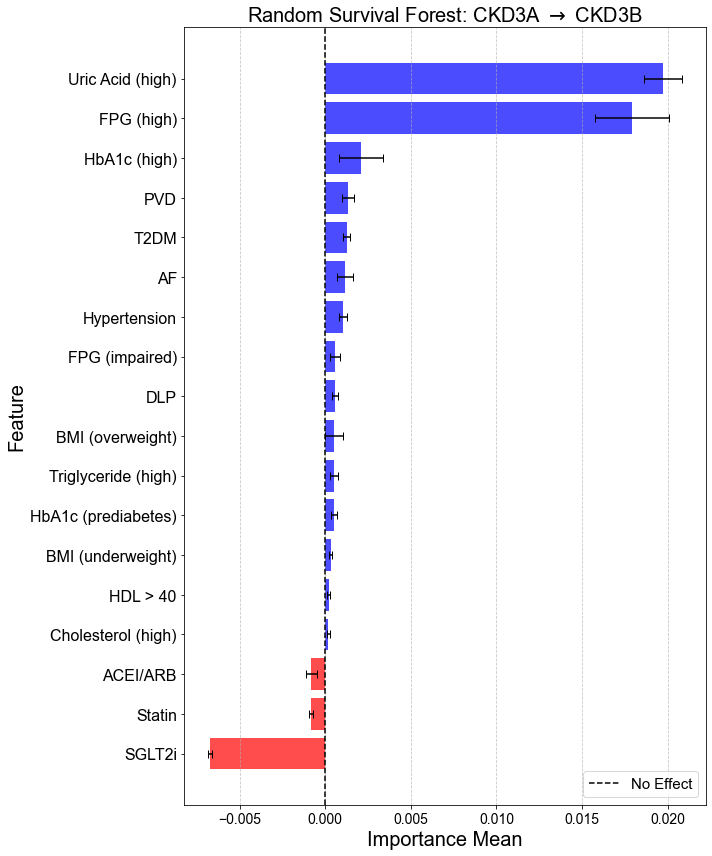

In [82]:
forest = False
bar = True

plt.rcParams['font.family'] = 'Arial'

model_name = 'randomsurvivalforest' # randomsurvivalforest, survivalsvm, gradientboosting
importance_path = resu_path + f'modeling/{model_name}/feature_importance/23December2024/'

model_title_dict = {
    'randomsurvivalforest': 'Random Survival Forest',
    'gradientboosting': 'Gradient Boosting',
    'survivalsvm': 'Survival SVM'
}
model_title = model_title_dict.get(model_name, model_name)

for transition in unique_transitions:
    sheet = pd.read_csv(importance_path + f'{transition}.csv')
    sheet = sheet[sheet['feature'].isin(eligible_covariate)]
    sheet['lower_bound'] = sheet['importance_mean'] - sheet['importance_std']
    sheet['upper_bound'] = sheet['importance_mean'] + sheet['importance_std']

    sheet['feature'] = sheet['feature'].map(rename_dict).fillna(sheet['feature'])

    if bar:
        sheet = sheet.sort_values(by='importance_mean', ascending=False)
        formatted_transition = transition.replace('_to_', r' $\rightarrow$ ')
        
        colors = ['red' if val < 0 else 'blue' for val in sheet['importance_mean']]
        
        plt.figure(figsize=(10, 12))
        plt.barh(
            sheet['feature'], 
            sheet['importance_mean'], 
            xerr=[sheet['importance_mean'] - sheet['lower_bound'], sheet['upper_bound'] - sheet['importance_mean']],
            capsize = 4, 
            color=colors, 
            alpha = 0.7)
        
        plt.axvline(x = 0, color = 'black', linestyle = '--', label = 'No Effect')
        plt.xlabel('Importance Mean', fontsize = 20)
        plt.ylabel('Feature', fontsize = 20)
        plt.title(f'{model_title}: {formatted_transition}', fontsize = 20)
        plt.gca().invert_yaxis()
        plt.yticks(fontsize = 16)
        plt.xticks(fontsize = 14)
        plt.grid(axis='x', linestyle='--', alpha = 0.7)
        plt.legend(loc = 'lower right', fontsize = 15)
        plt.tight_layout()
        plt.savefig(importance_path + f'plots/{transition}.png', dpi = 500, bbox_inches = 'tight')
        plt.show()
        break

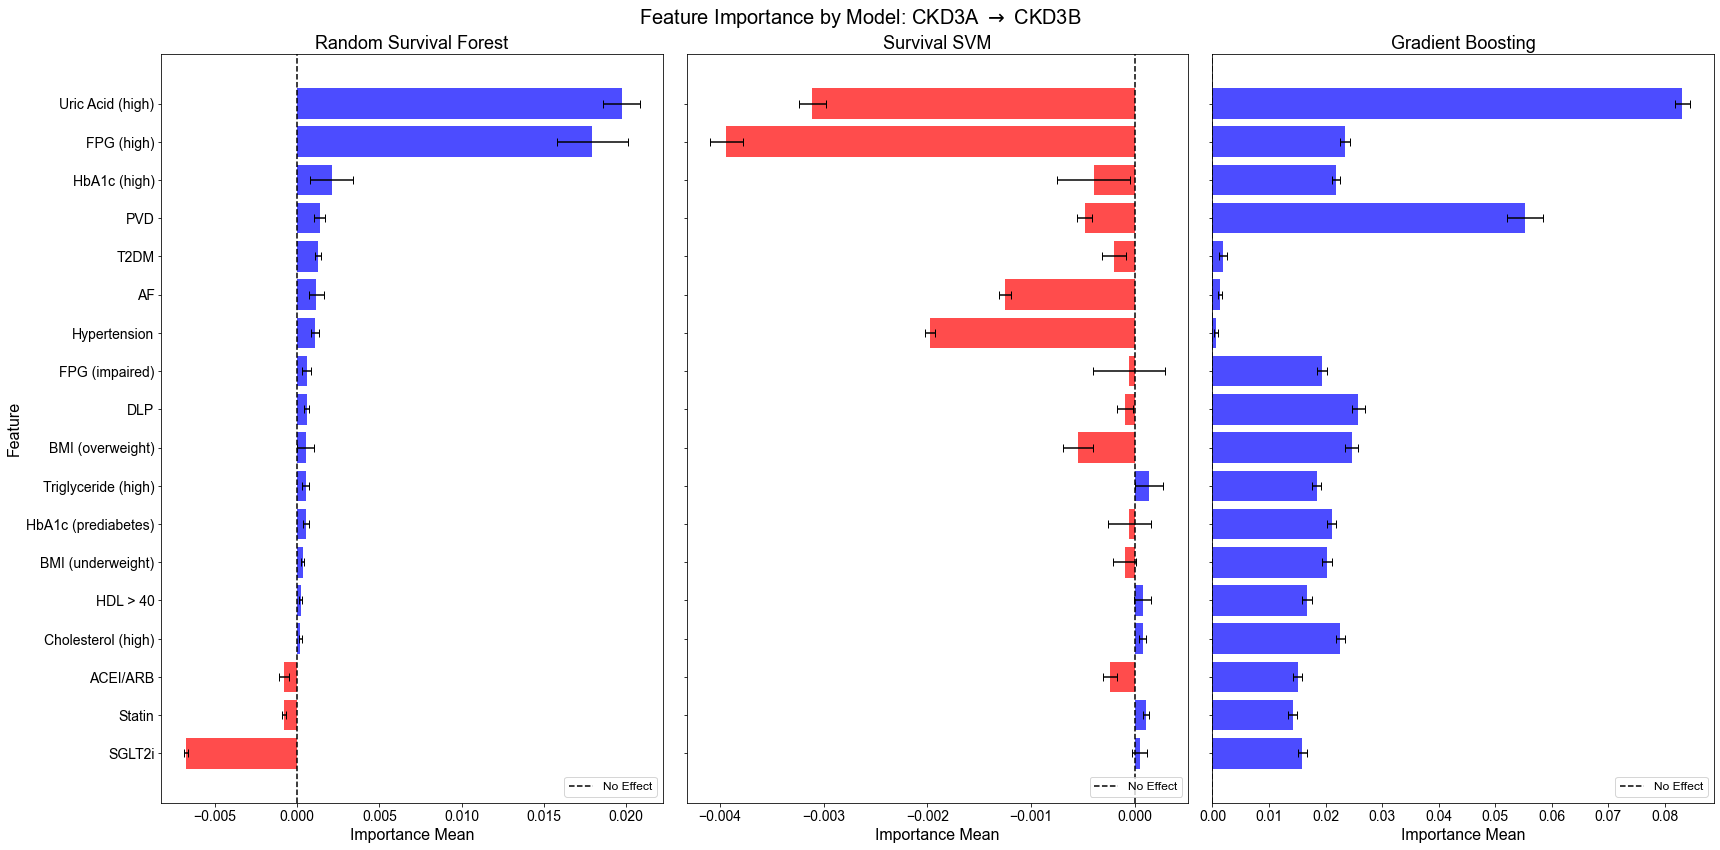

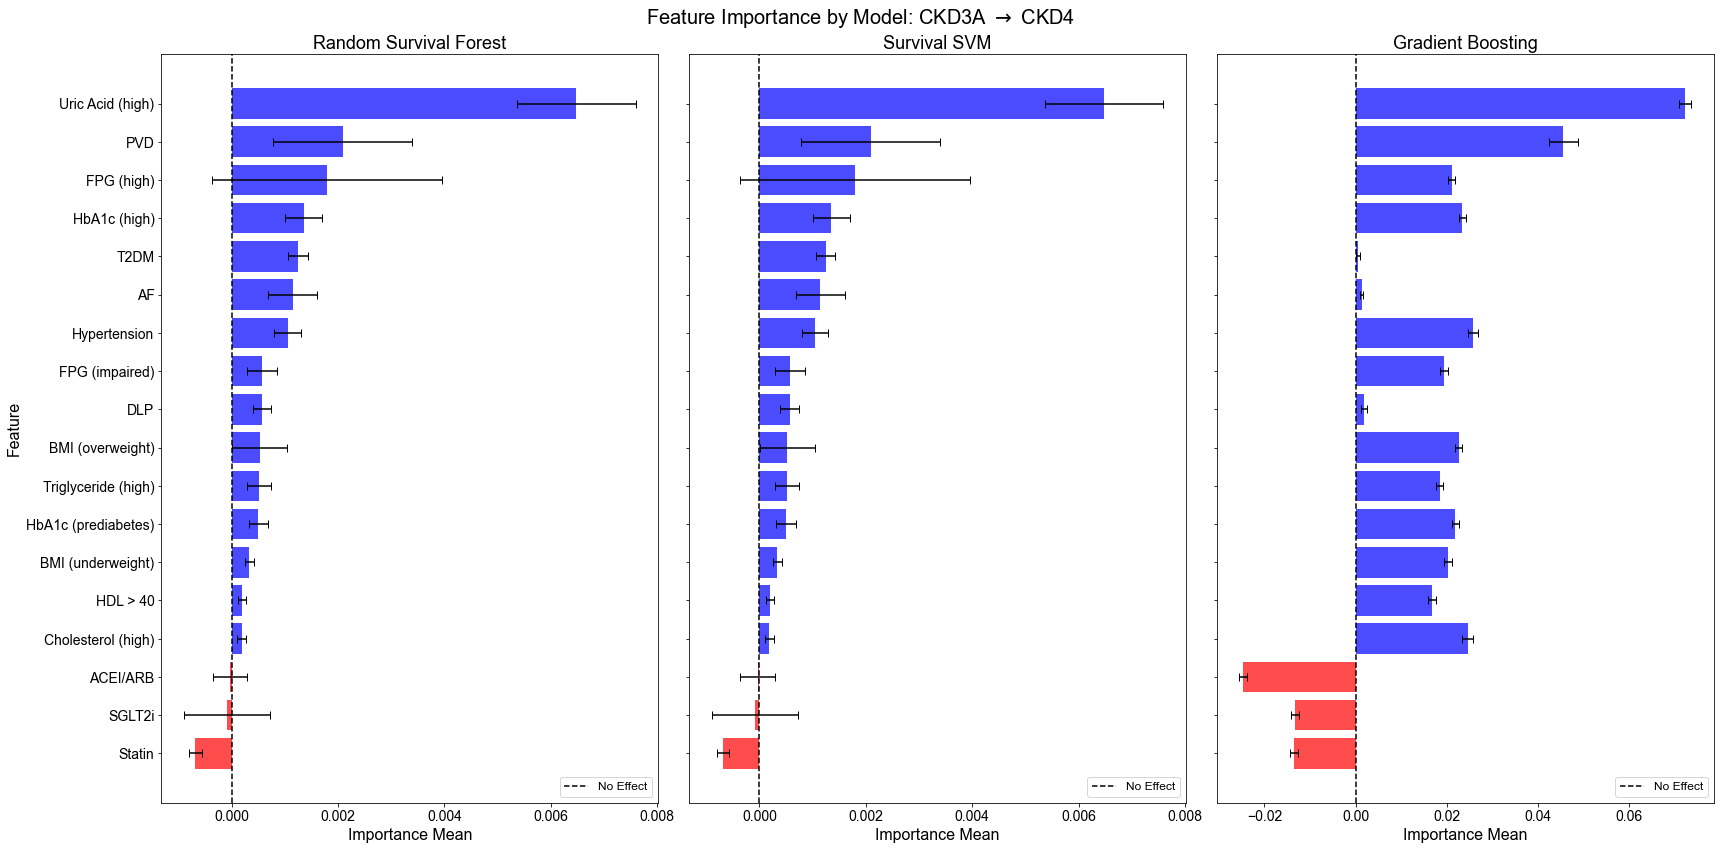

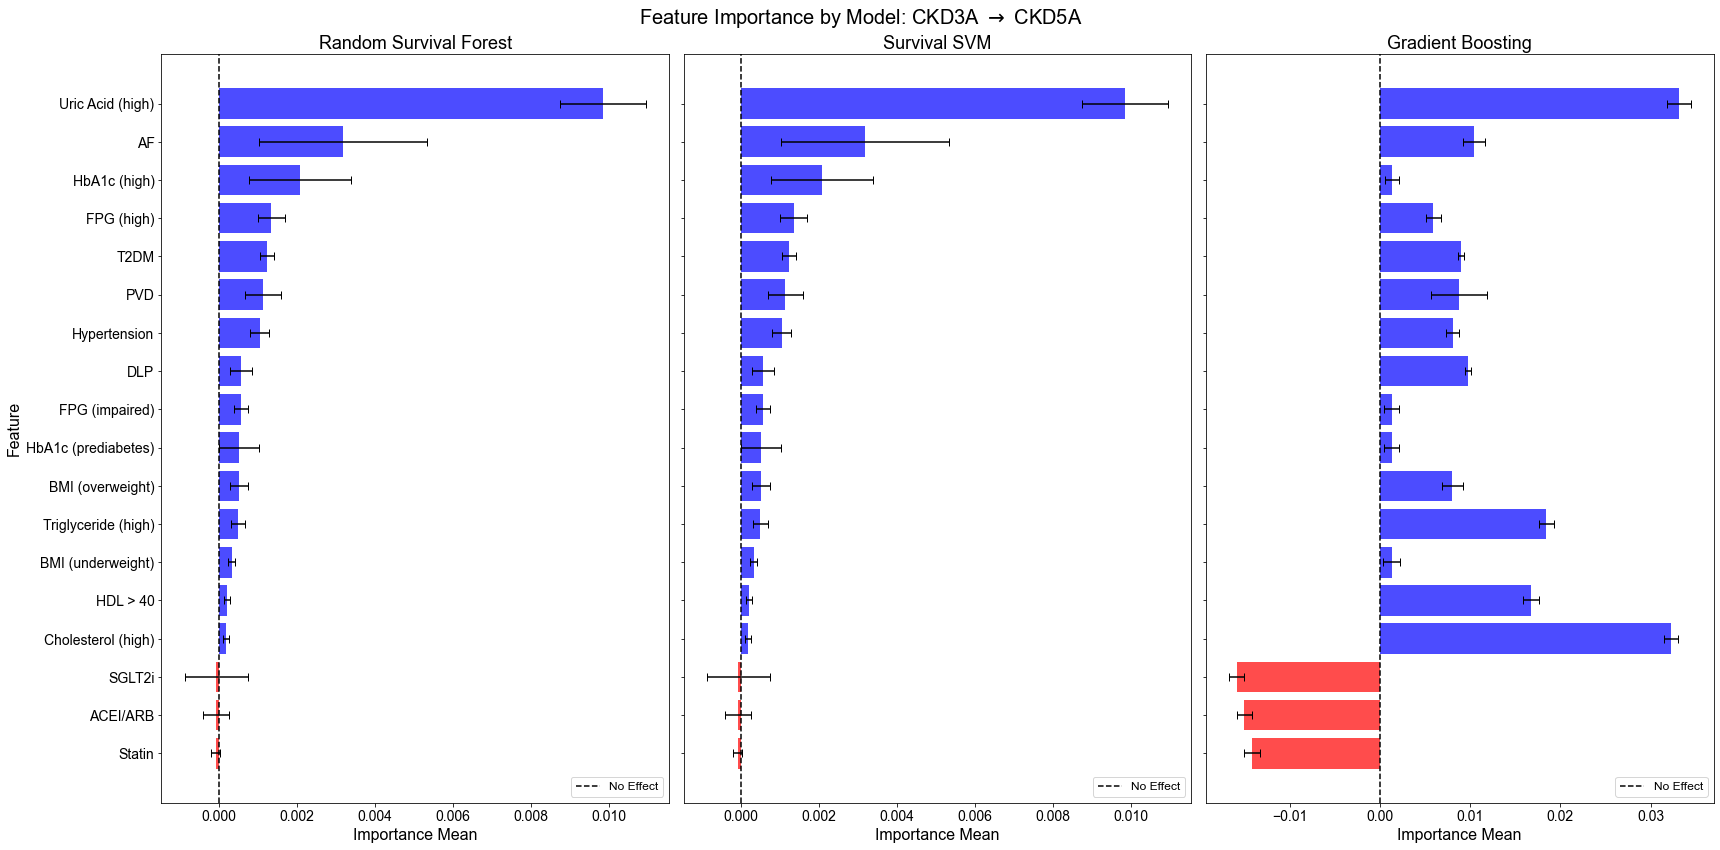

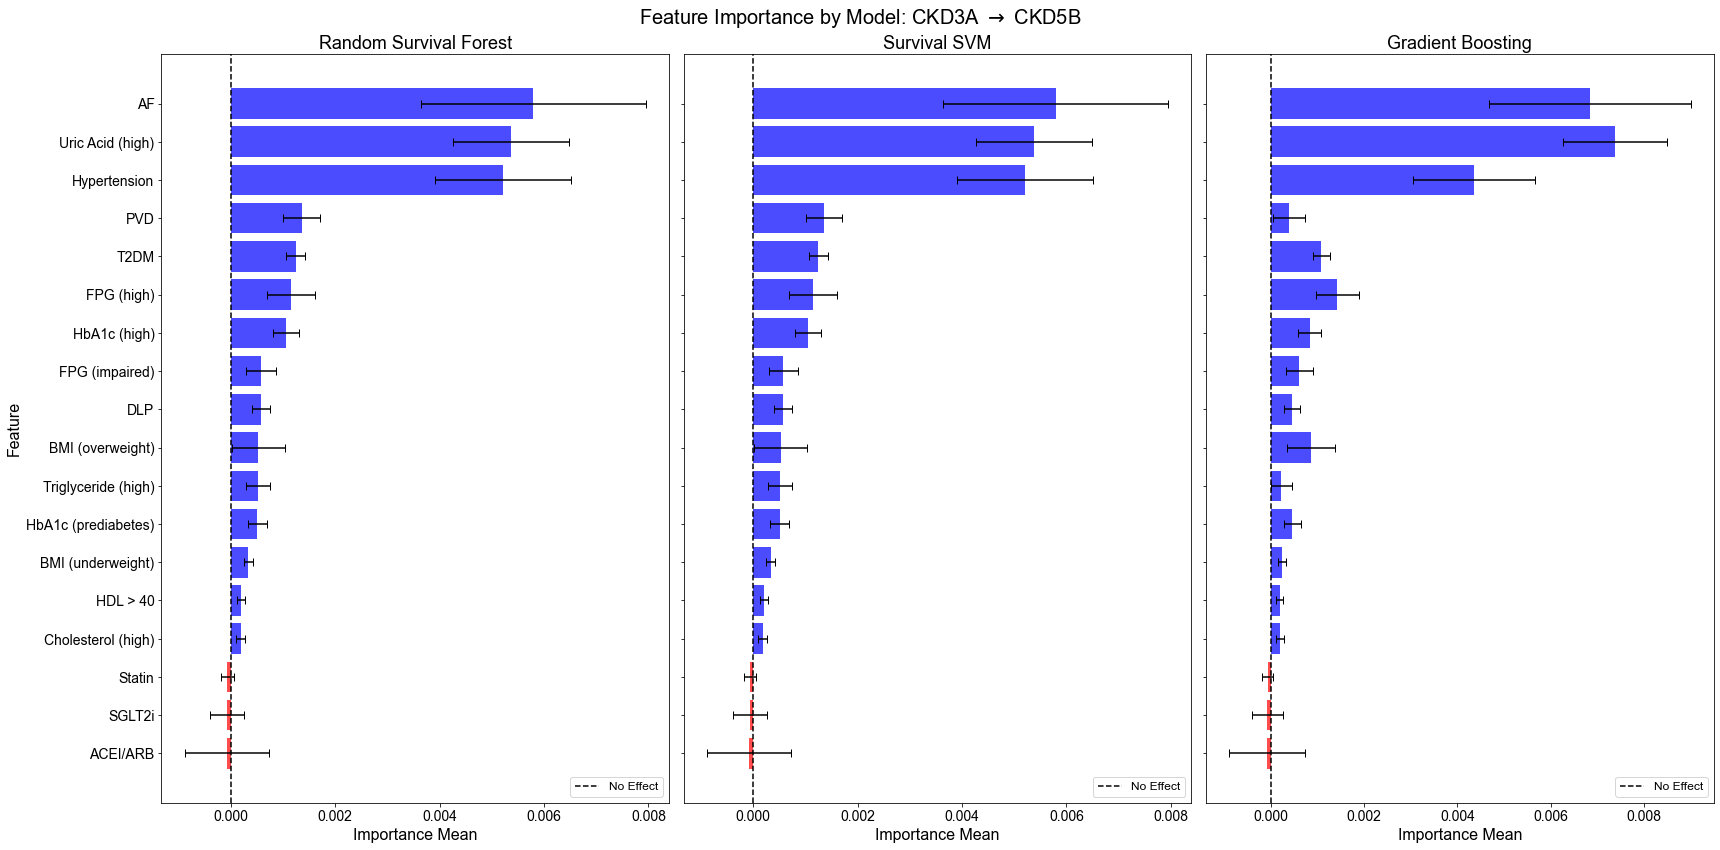

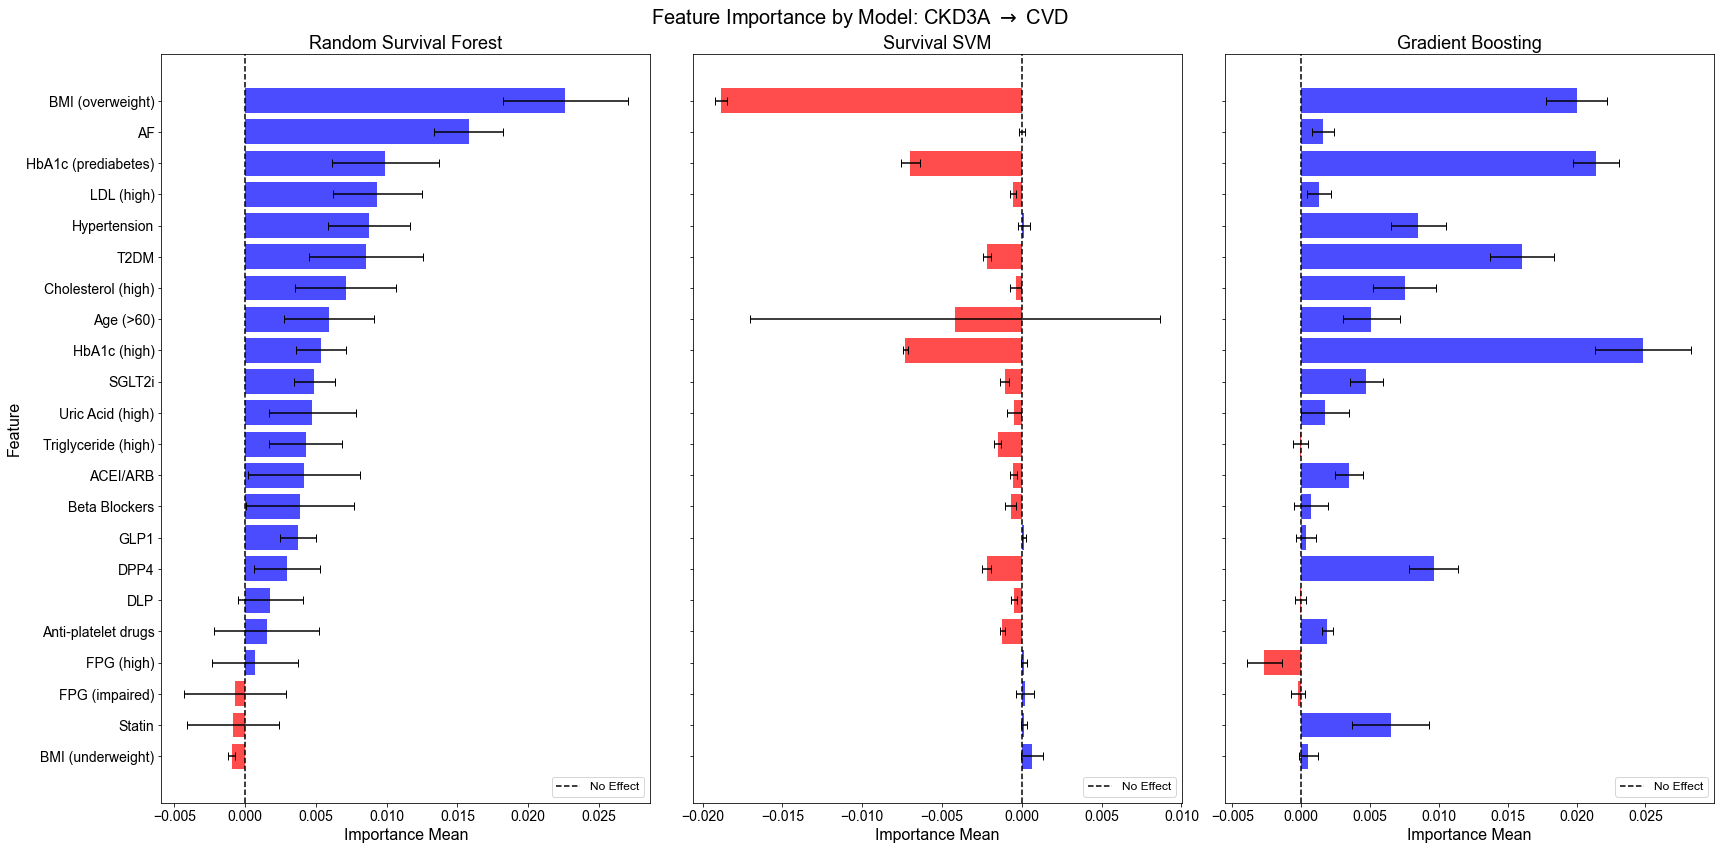

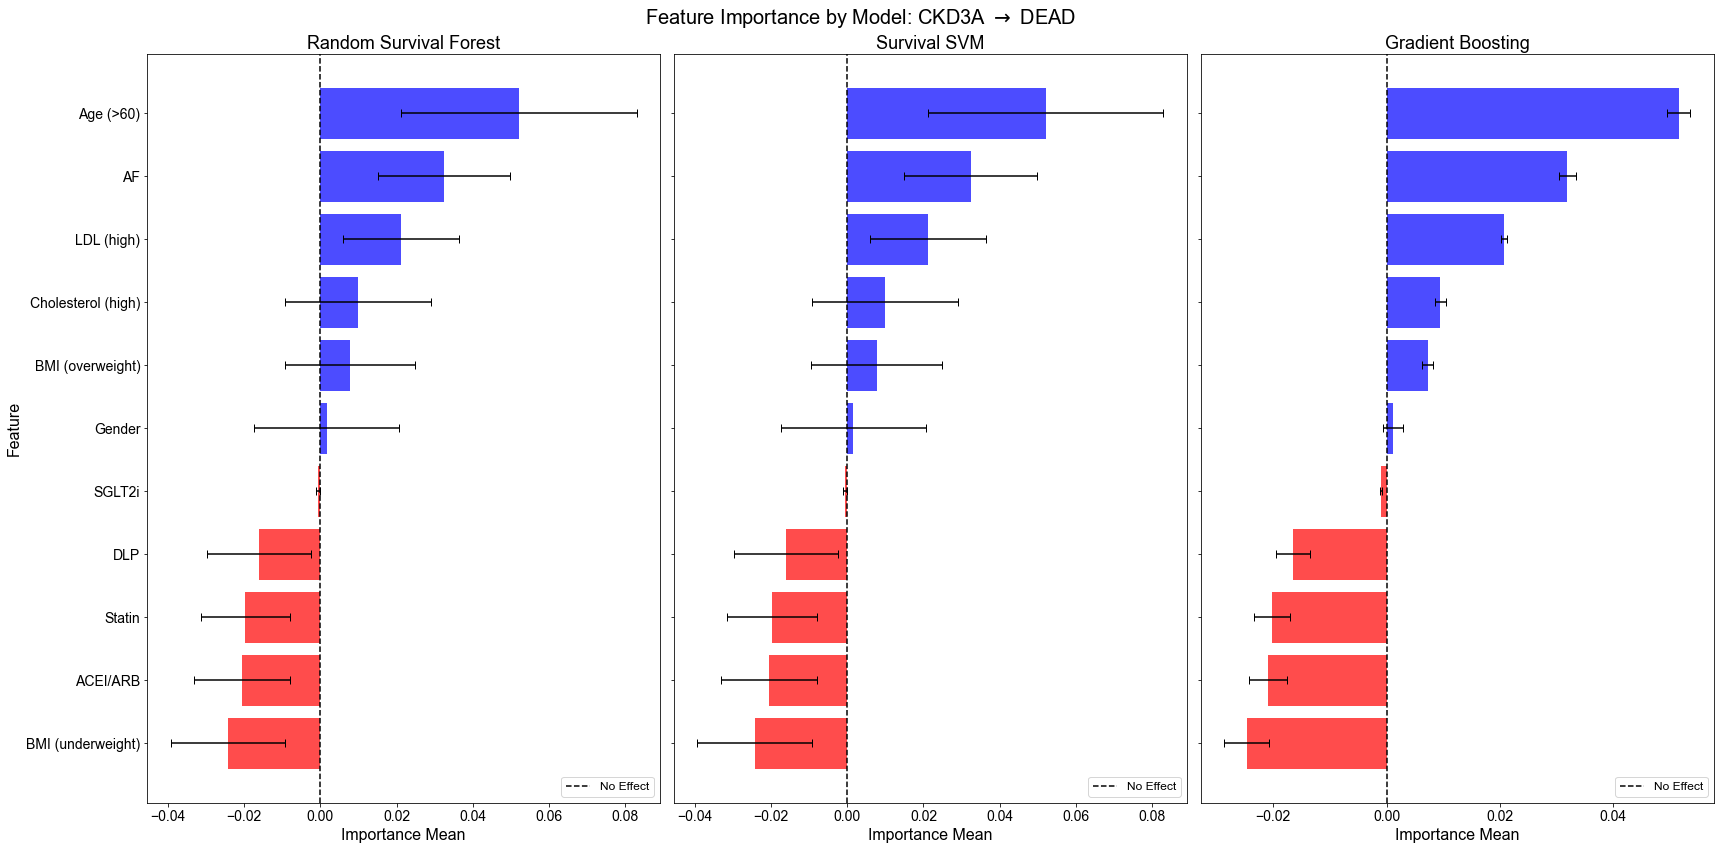

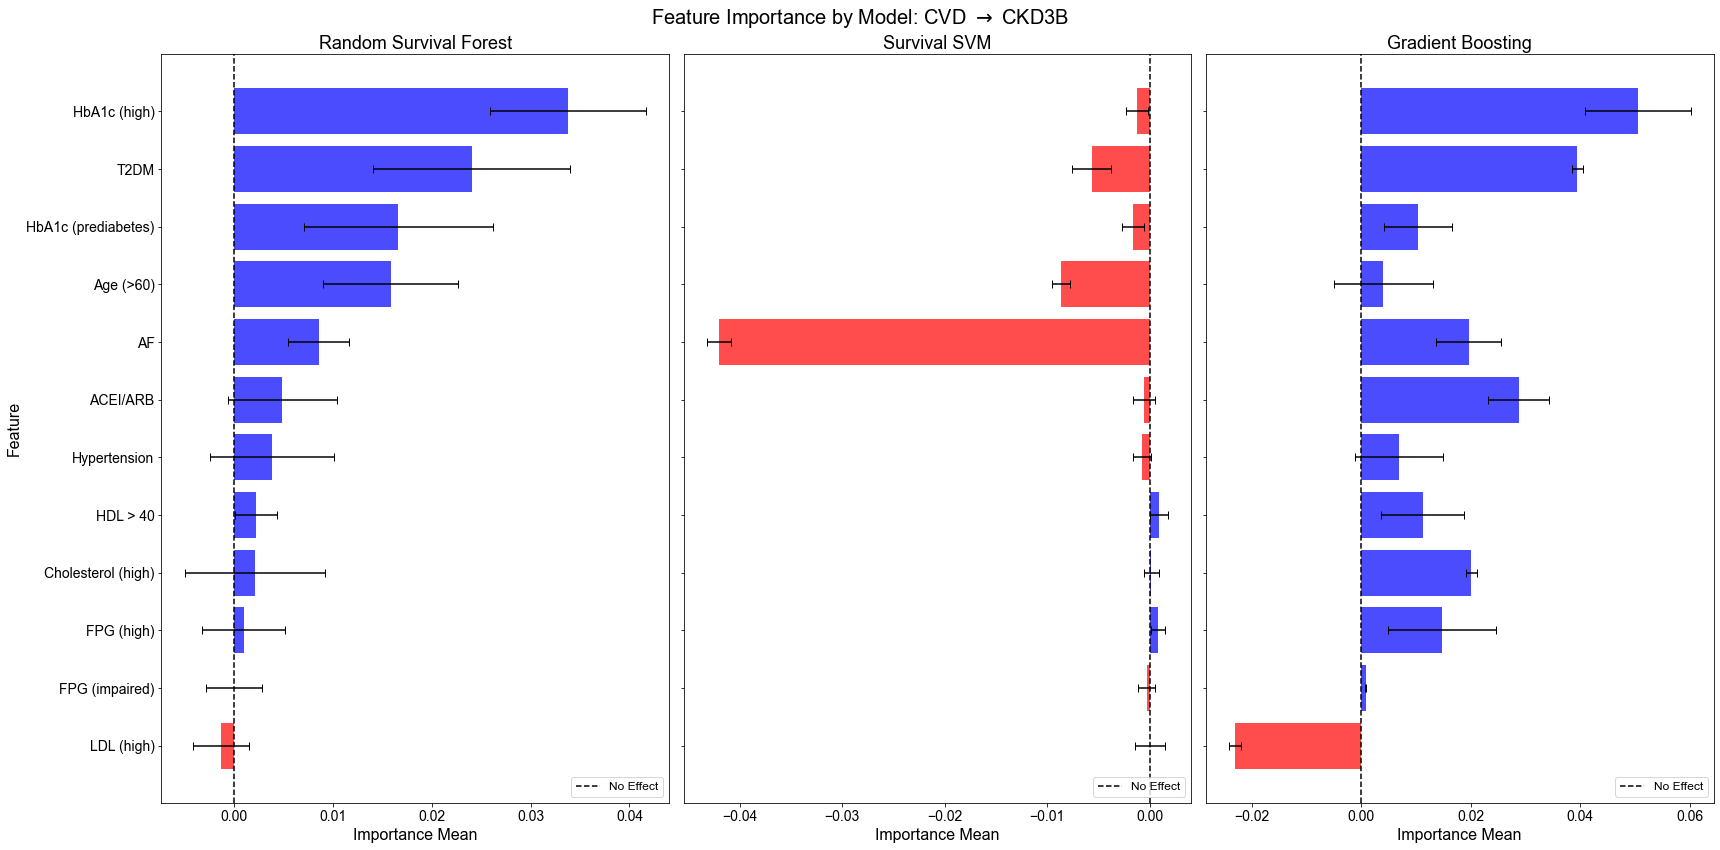

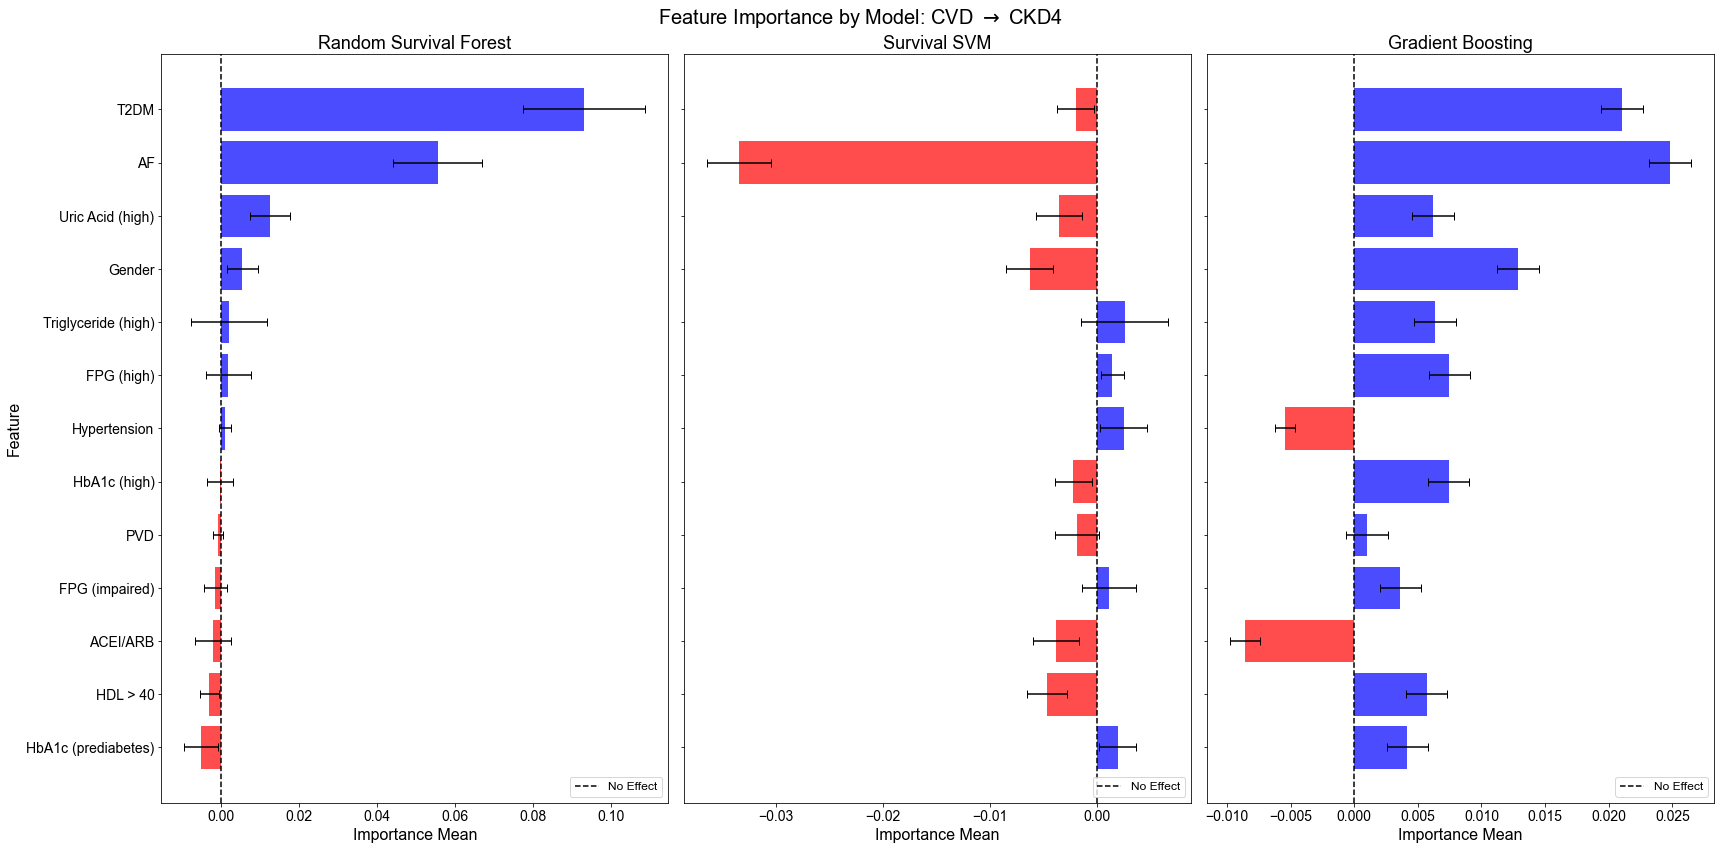

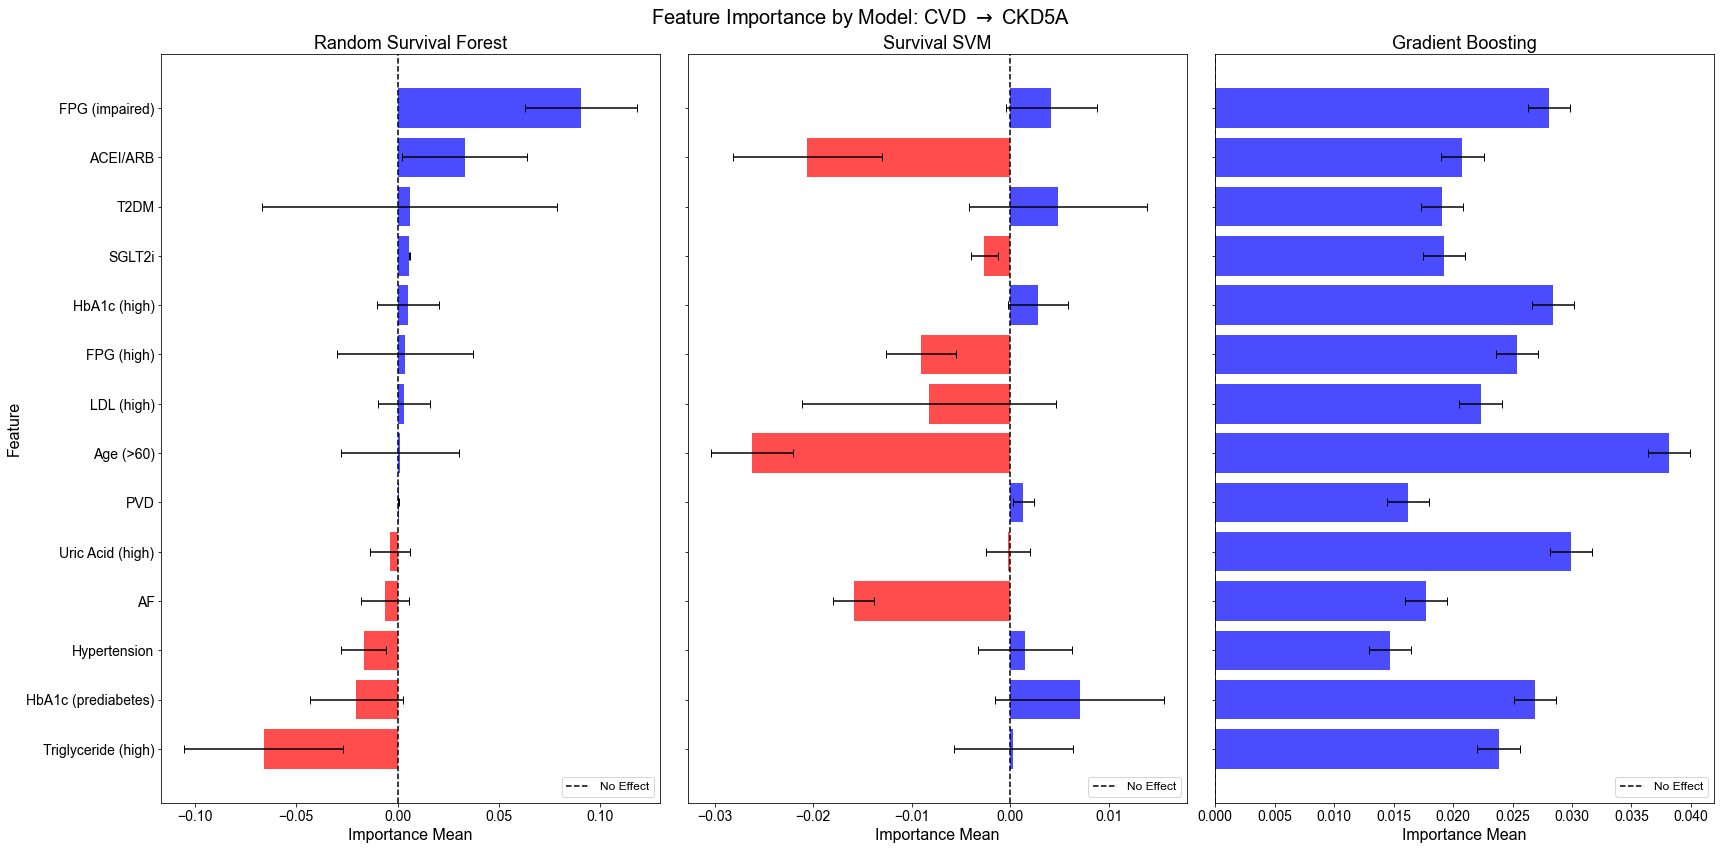

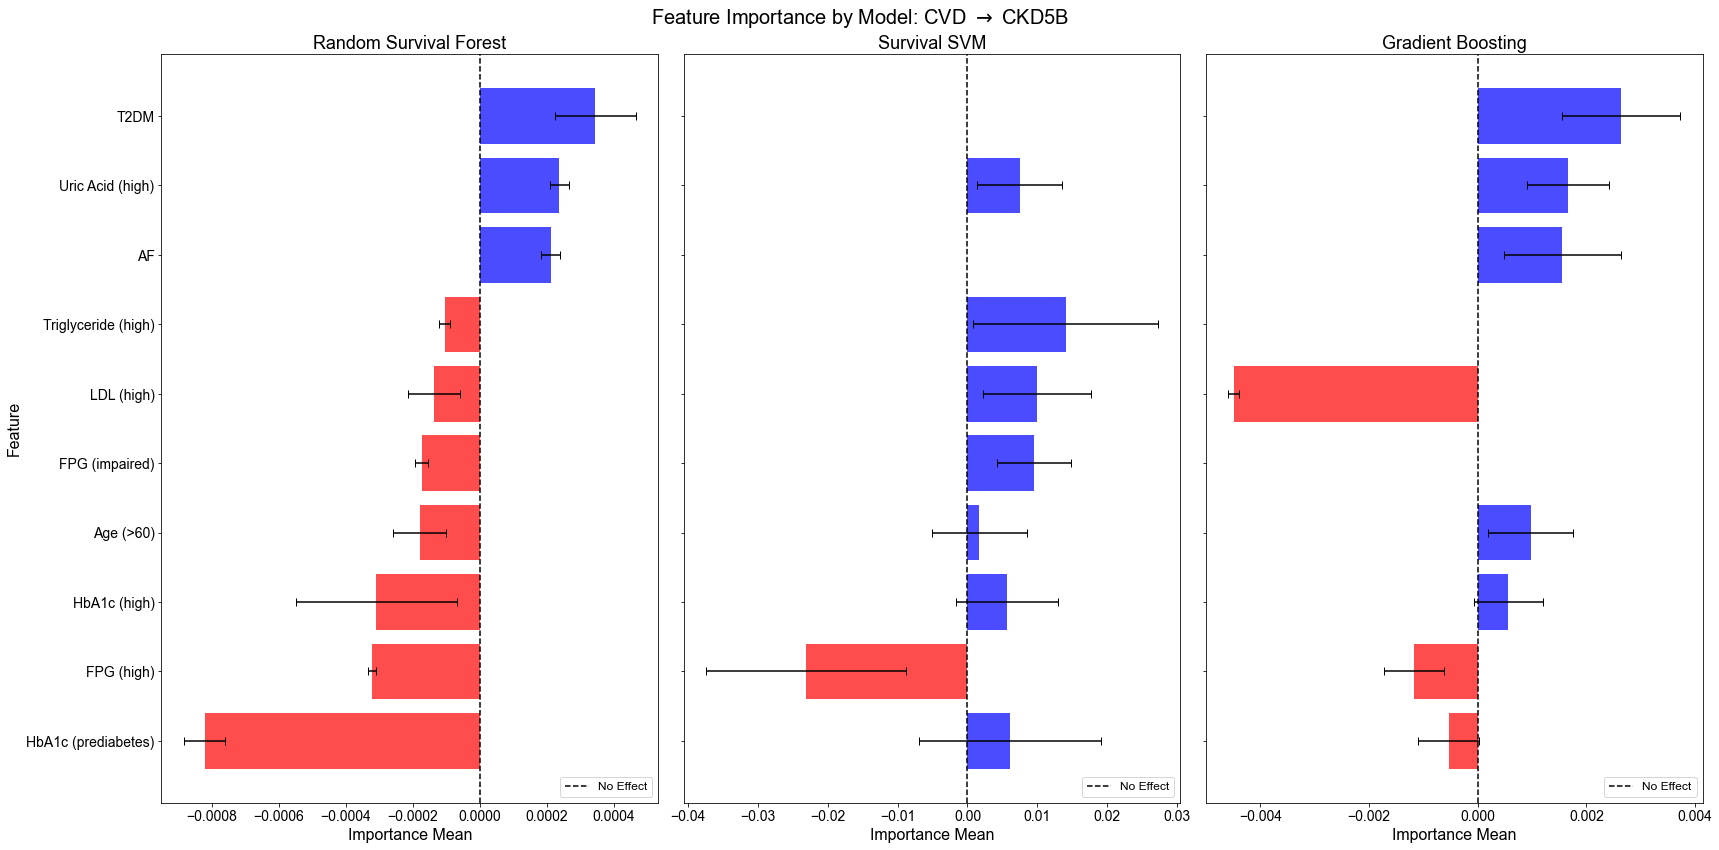

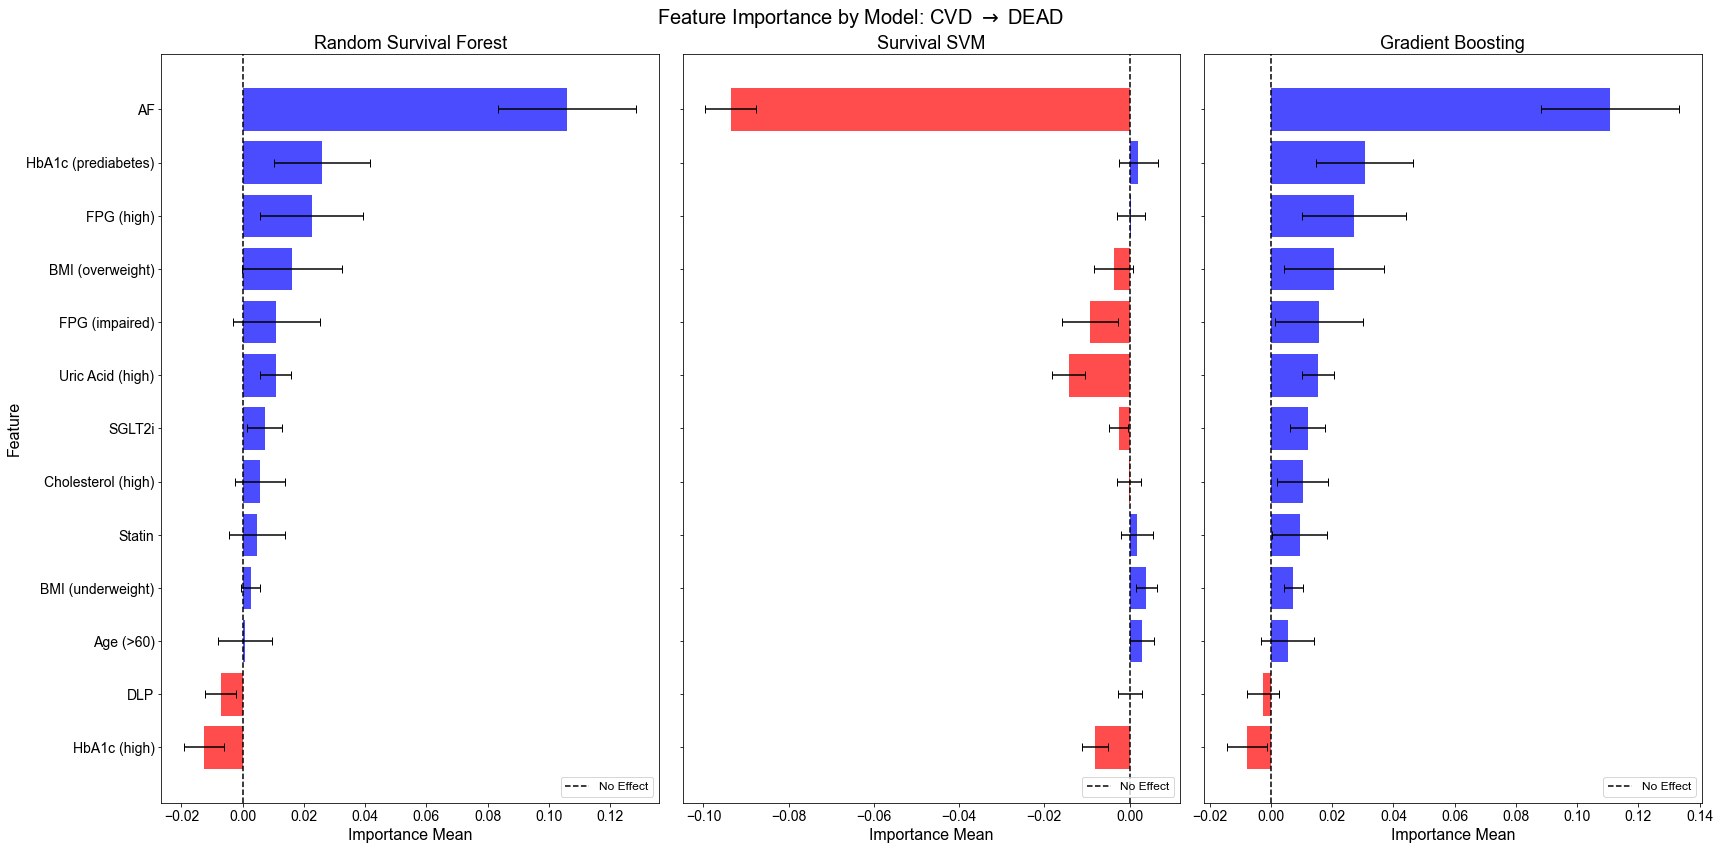

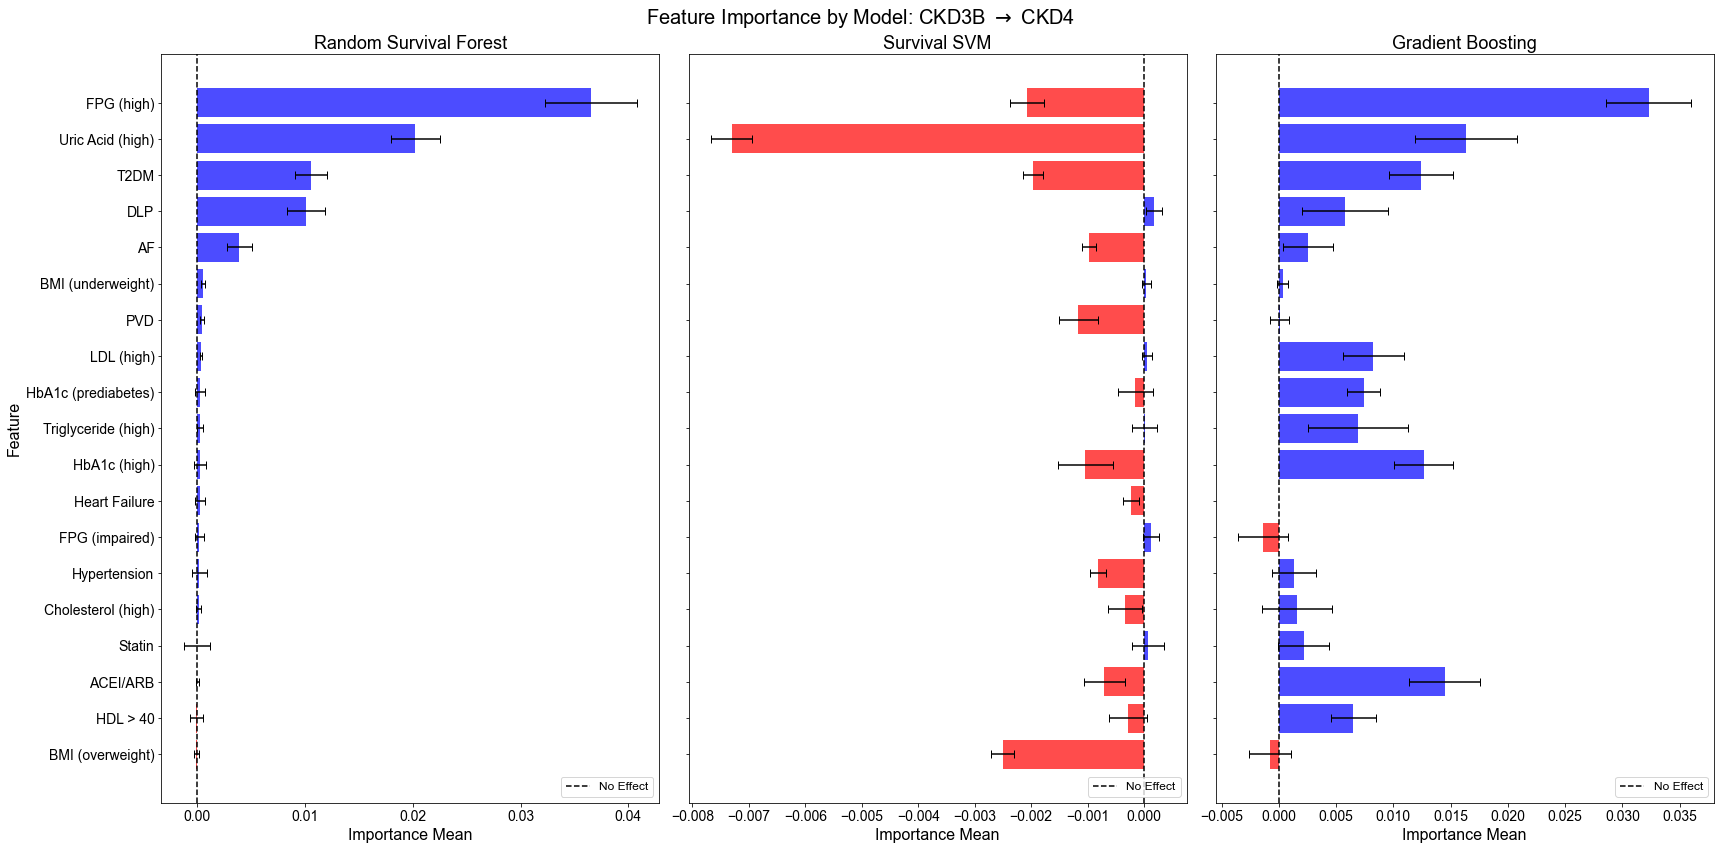

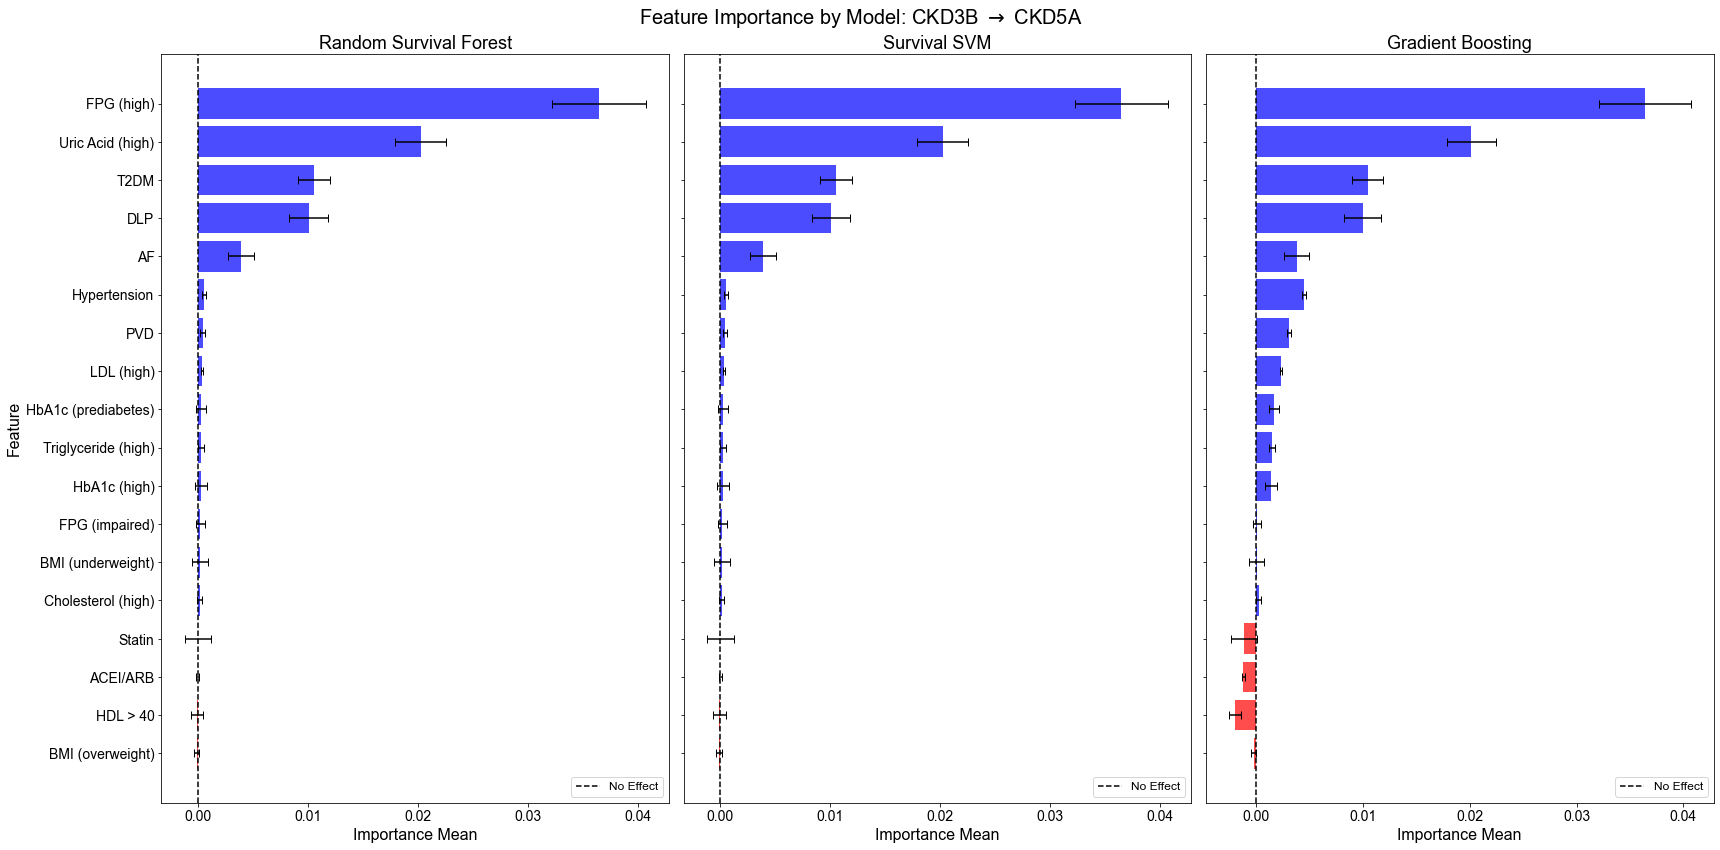

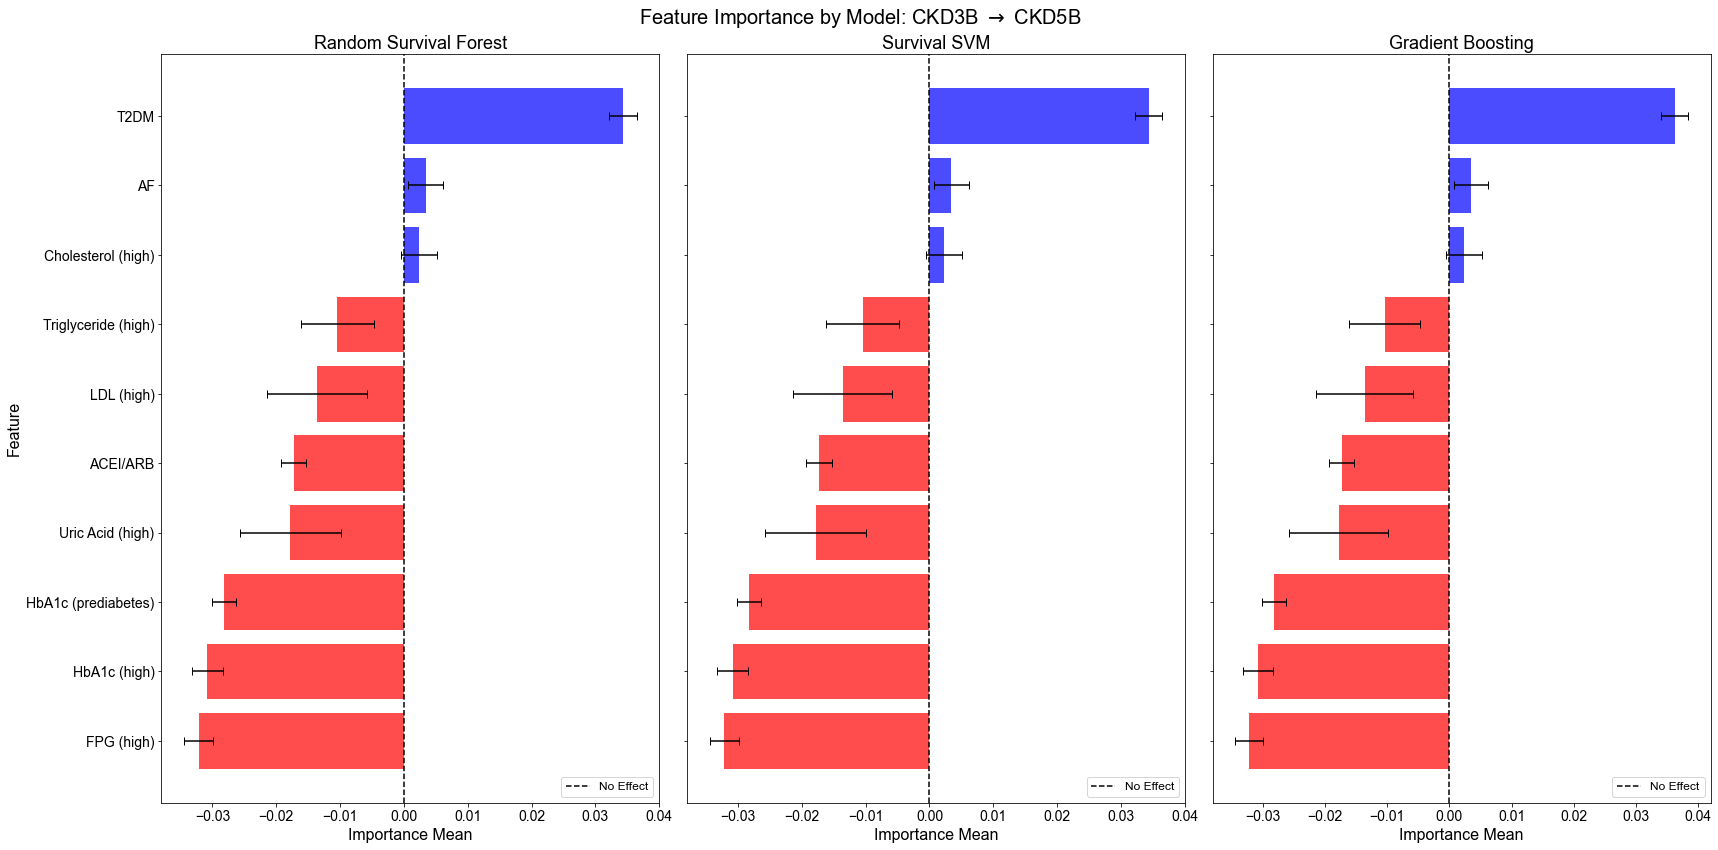

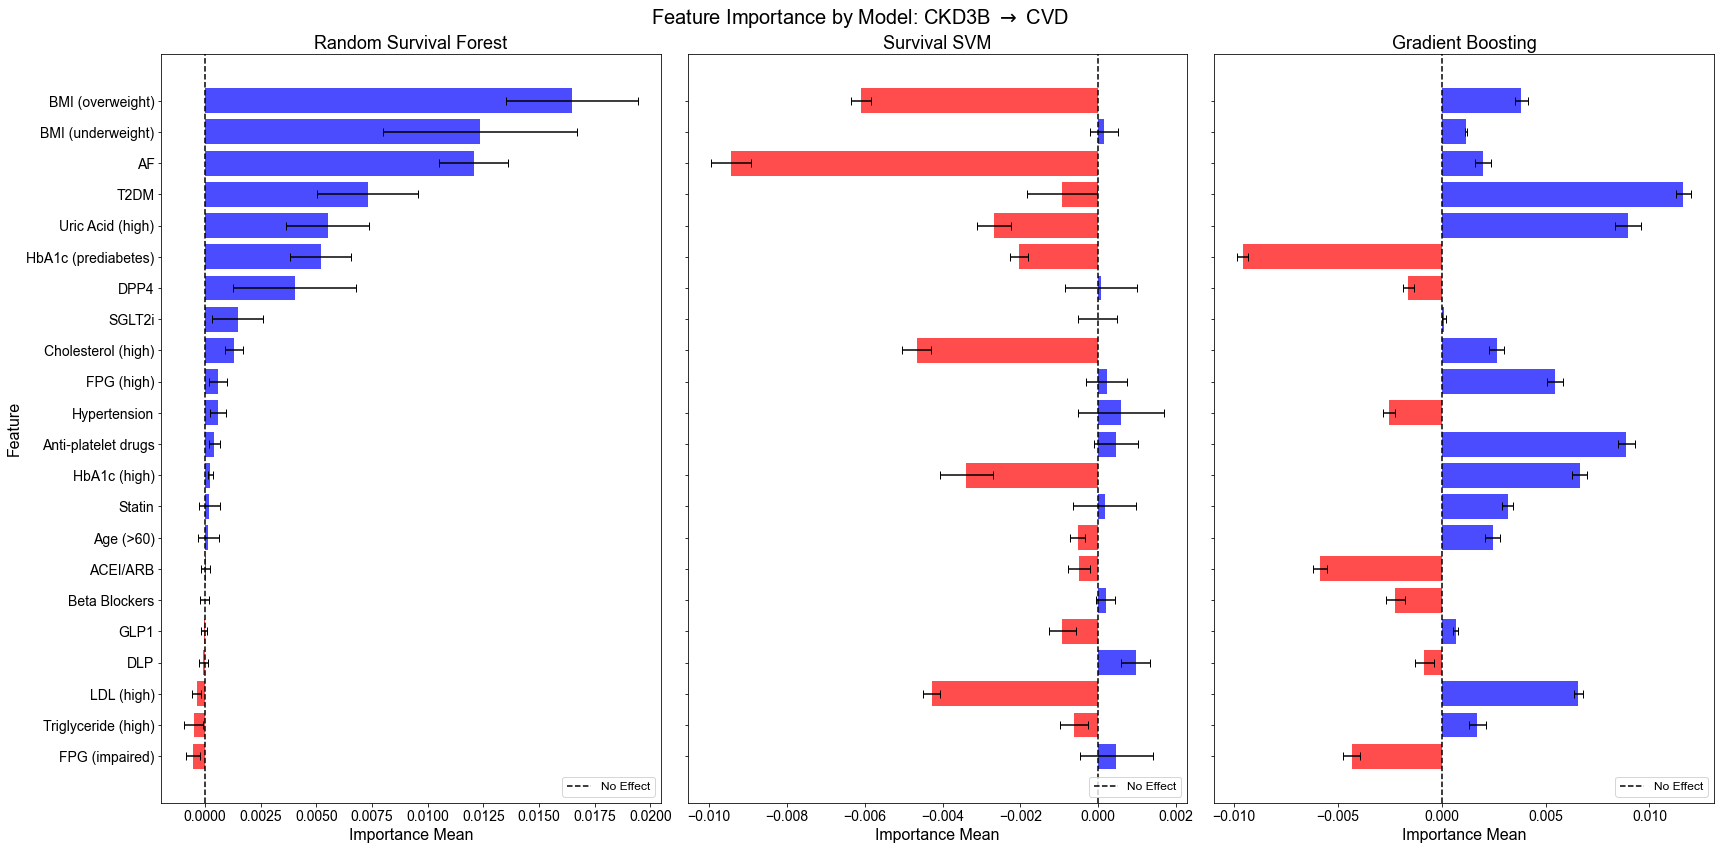

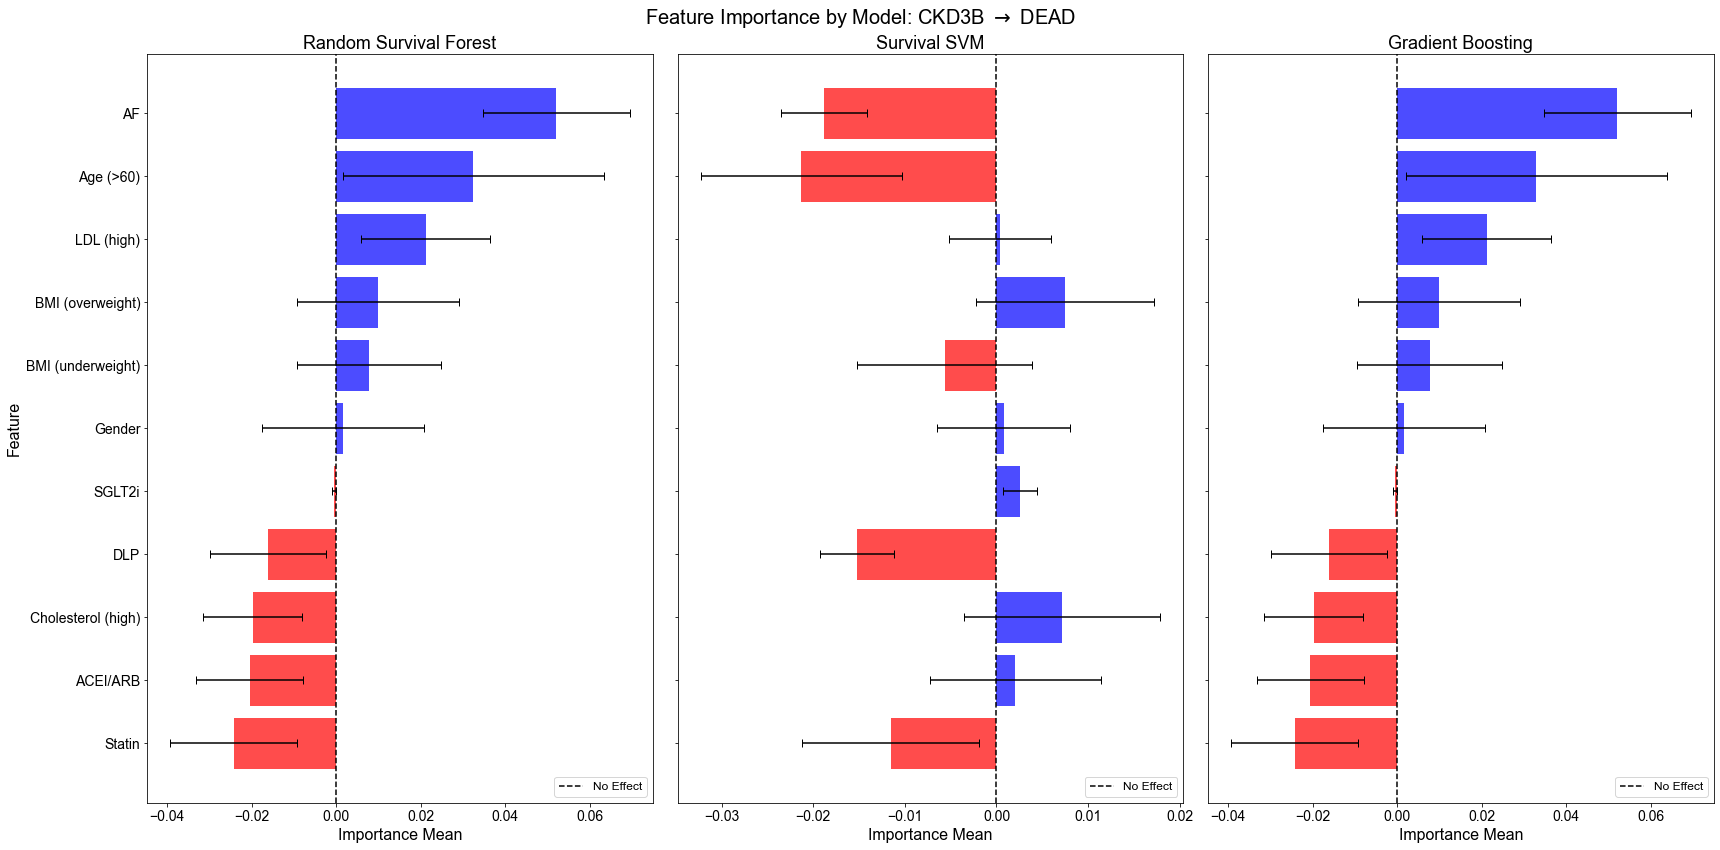

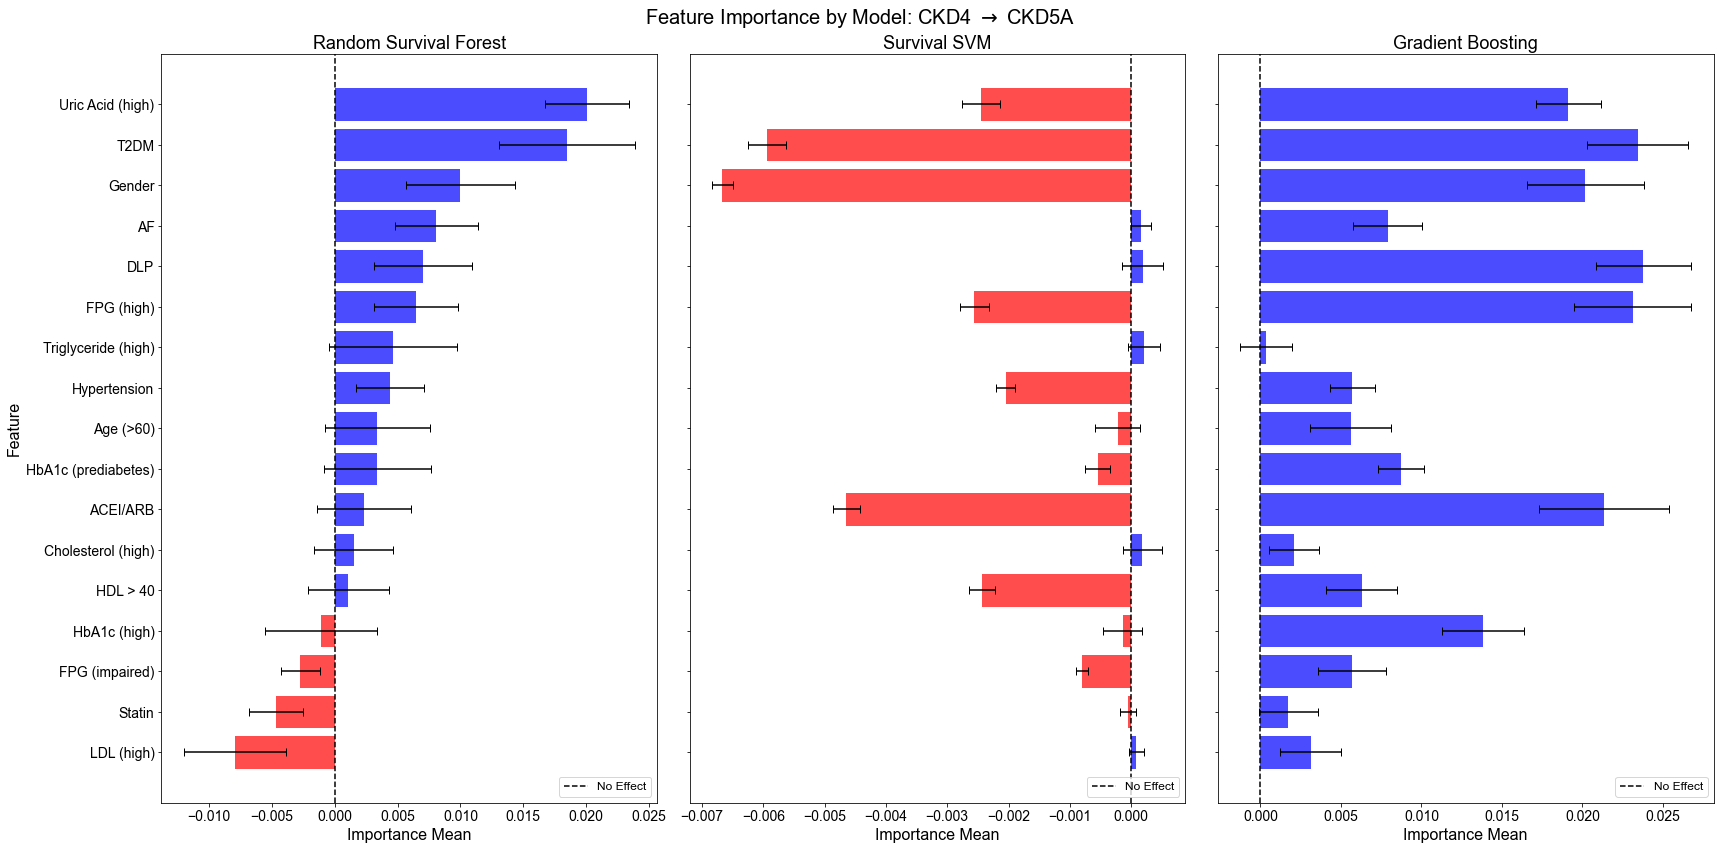

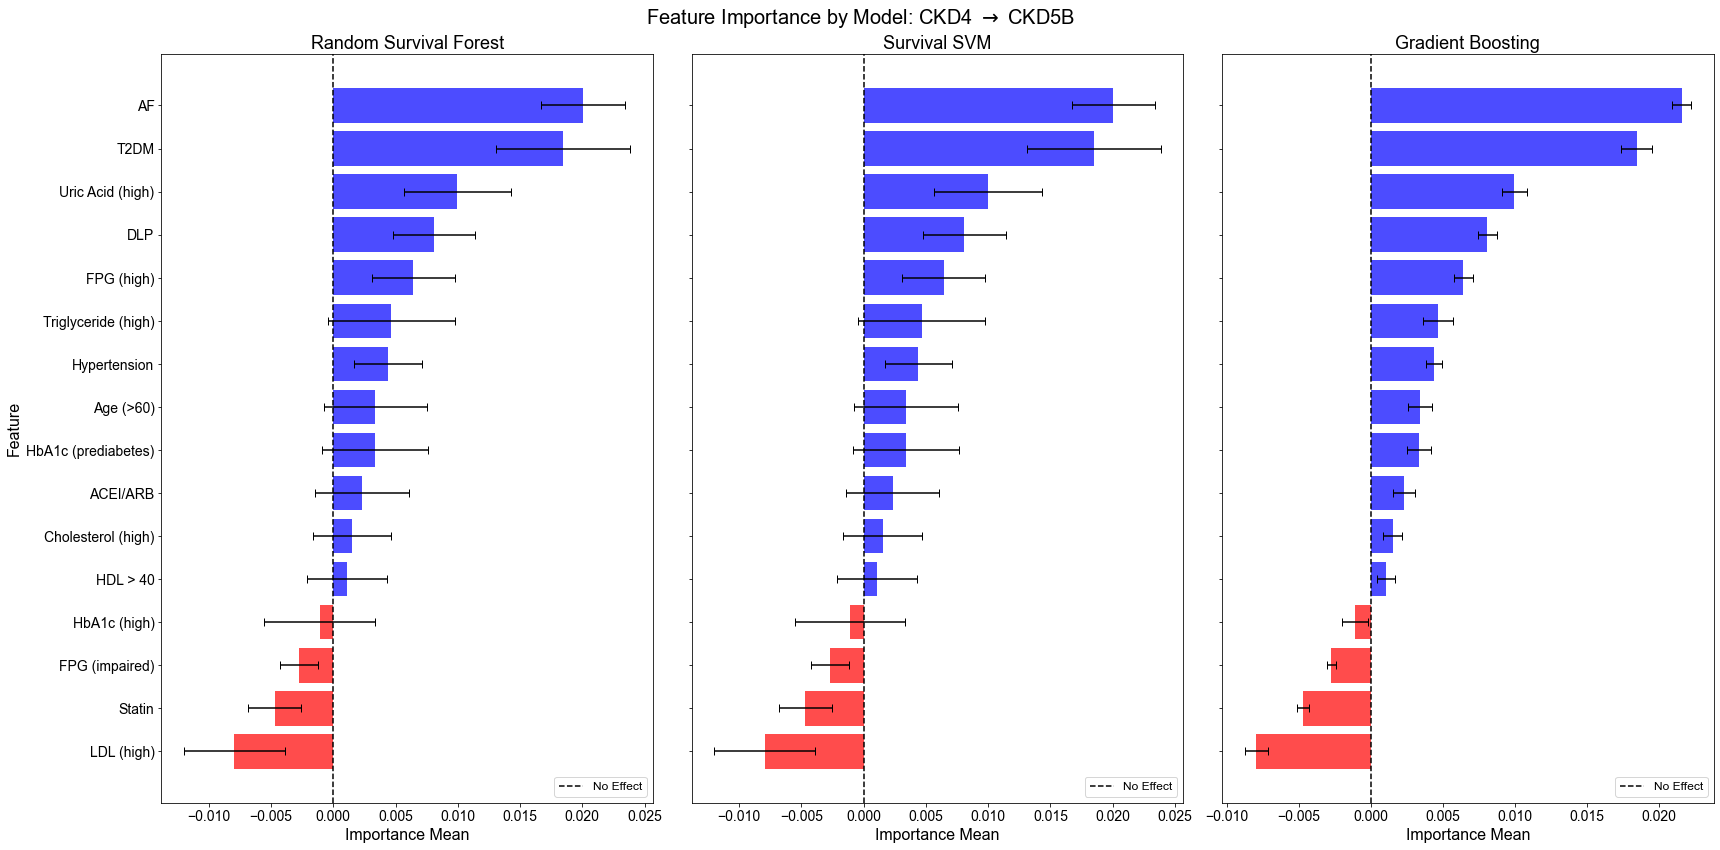

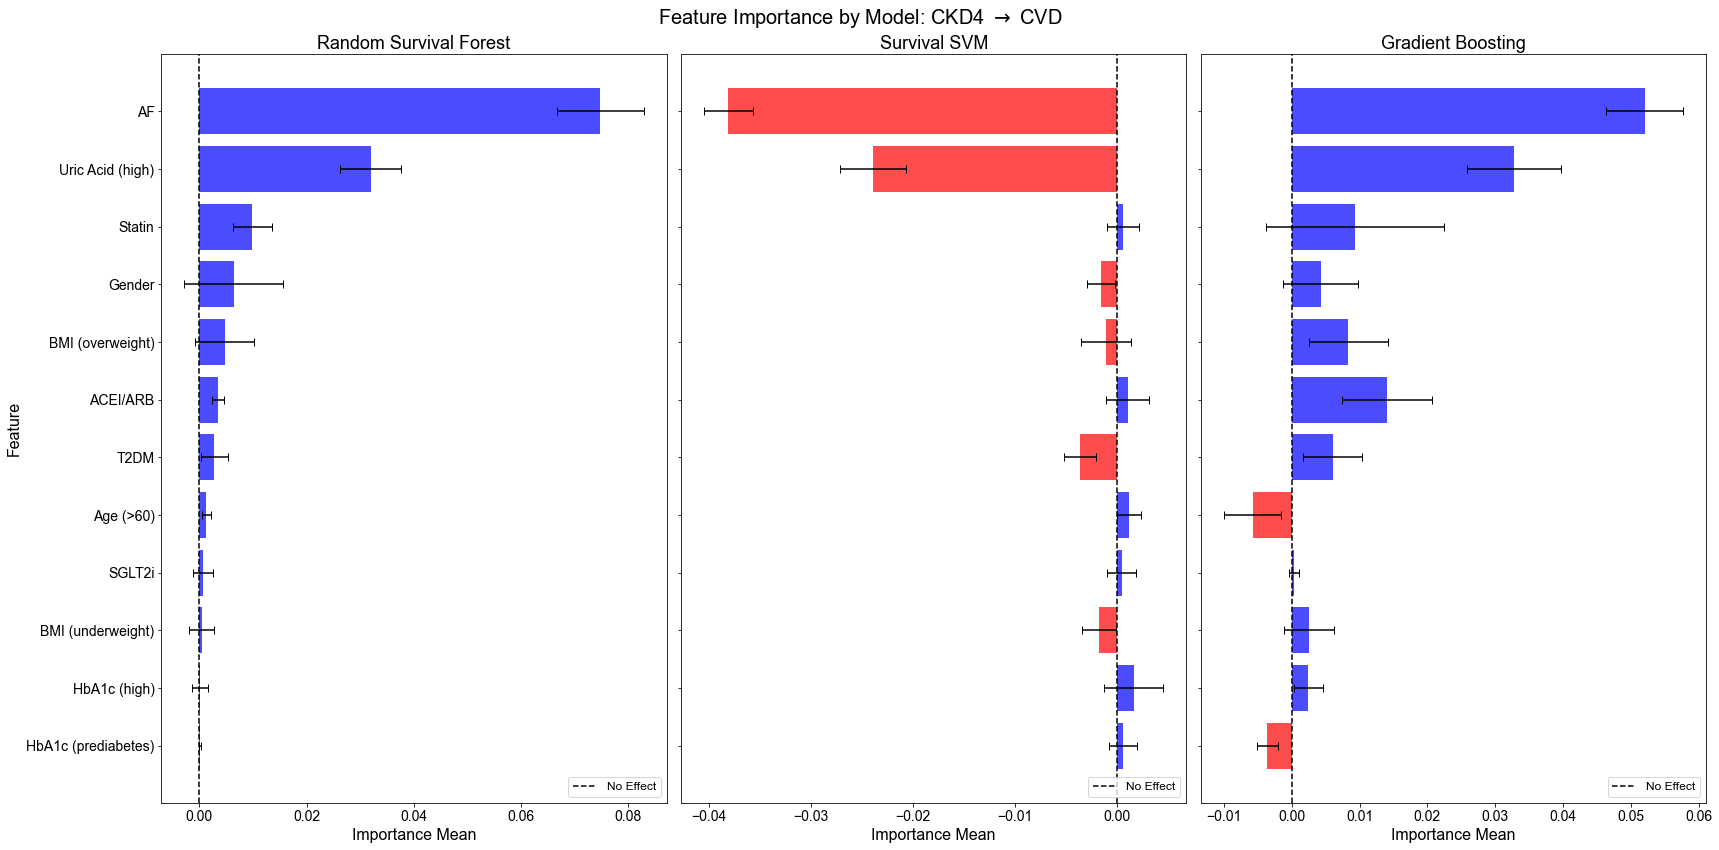

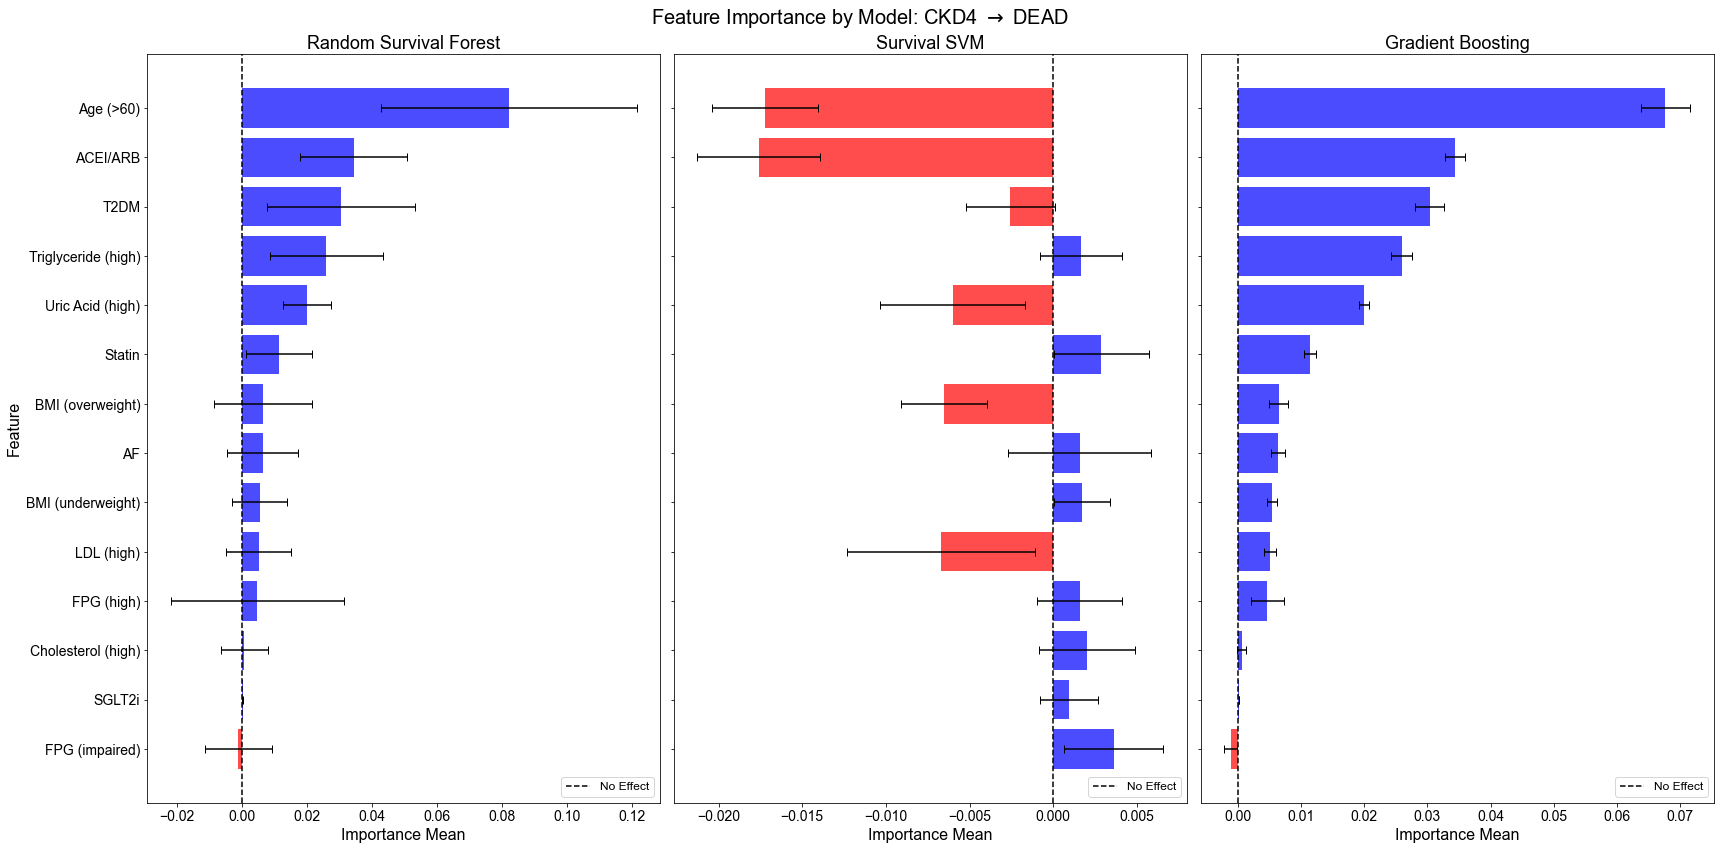

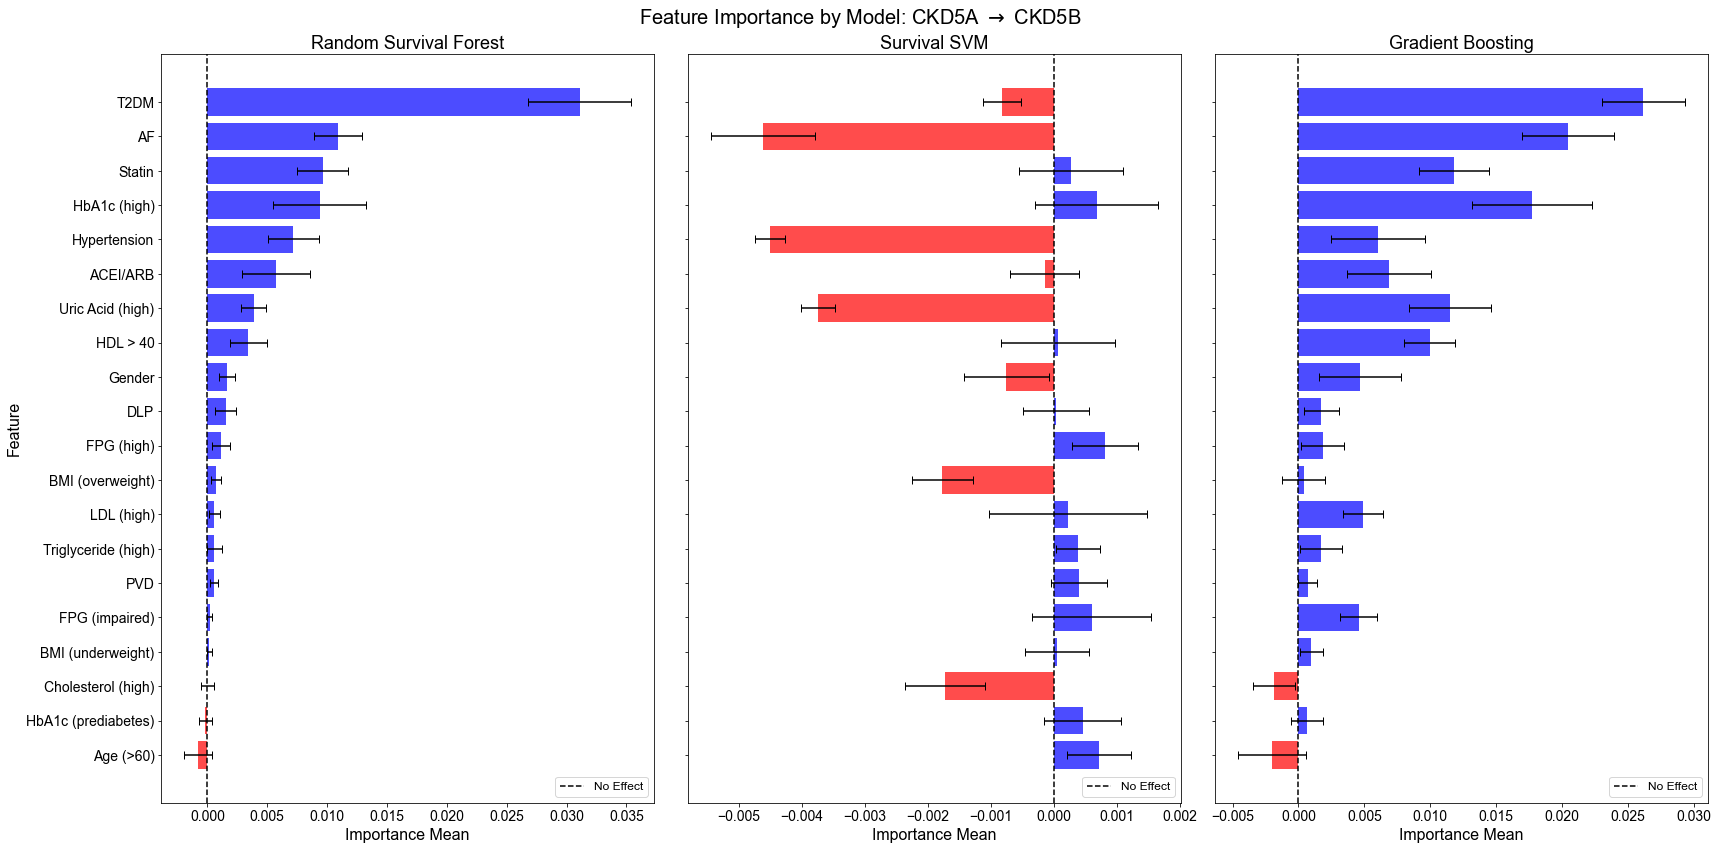

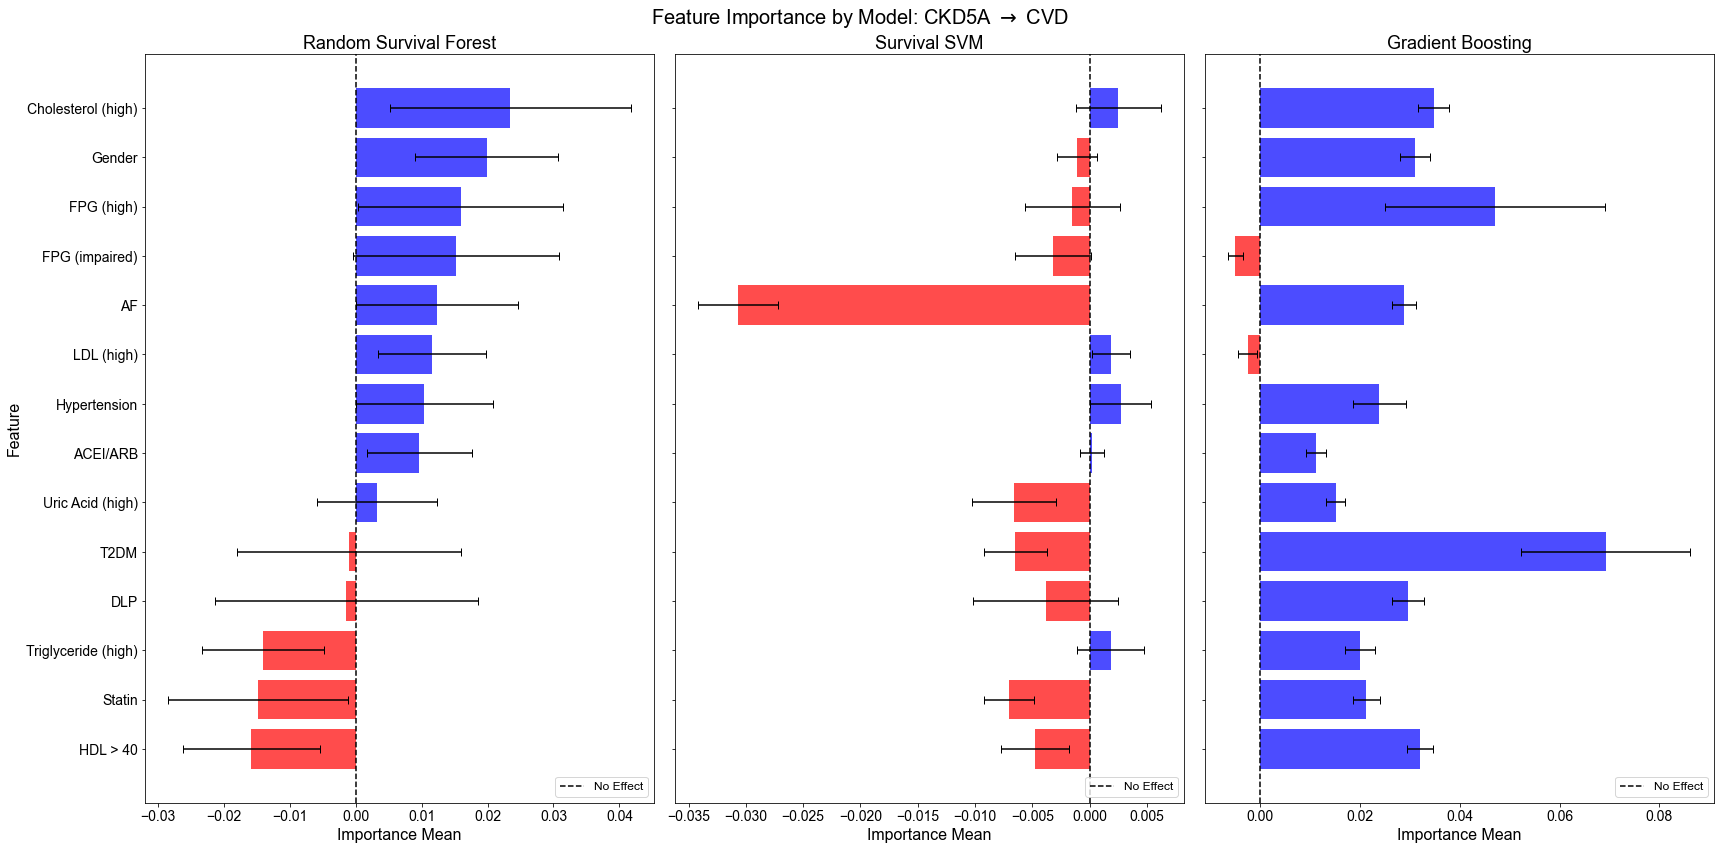

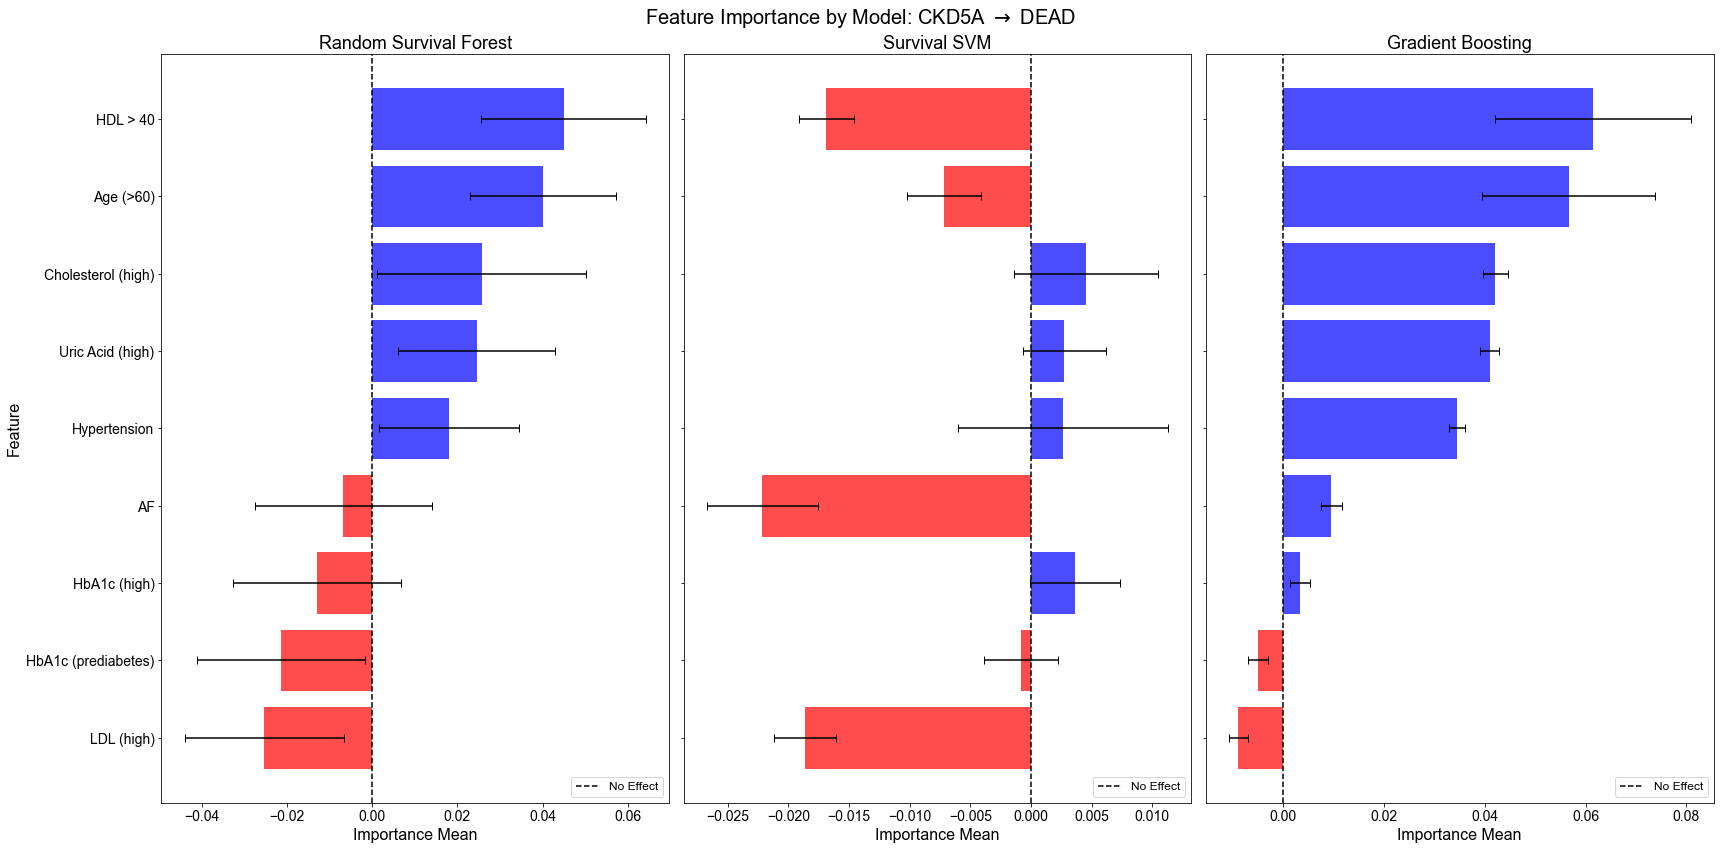

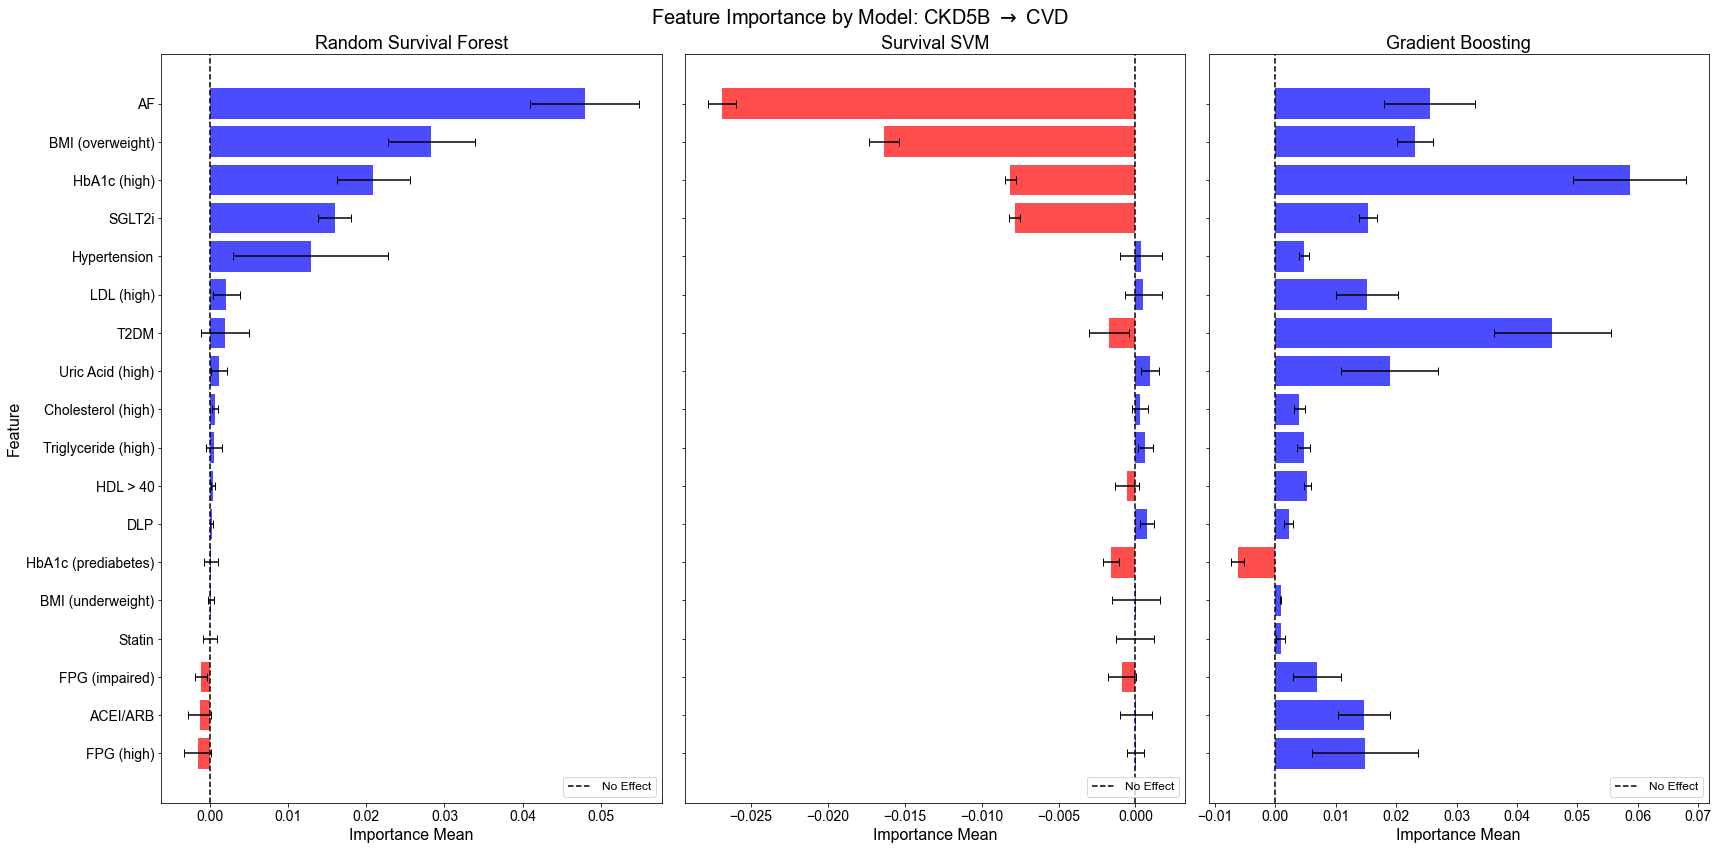

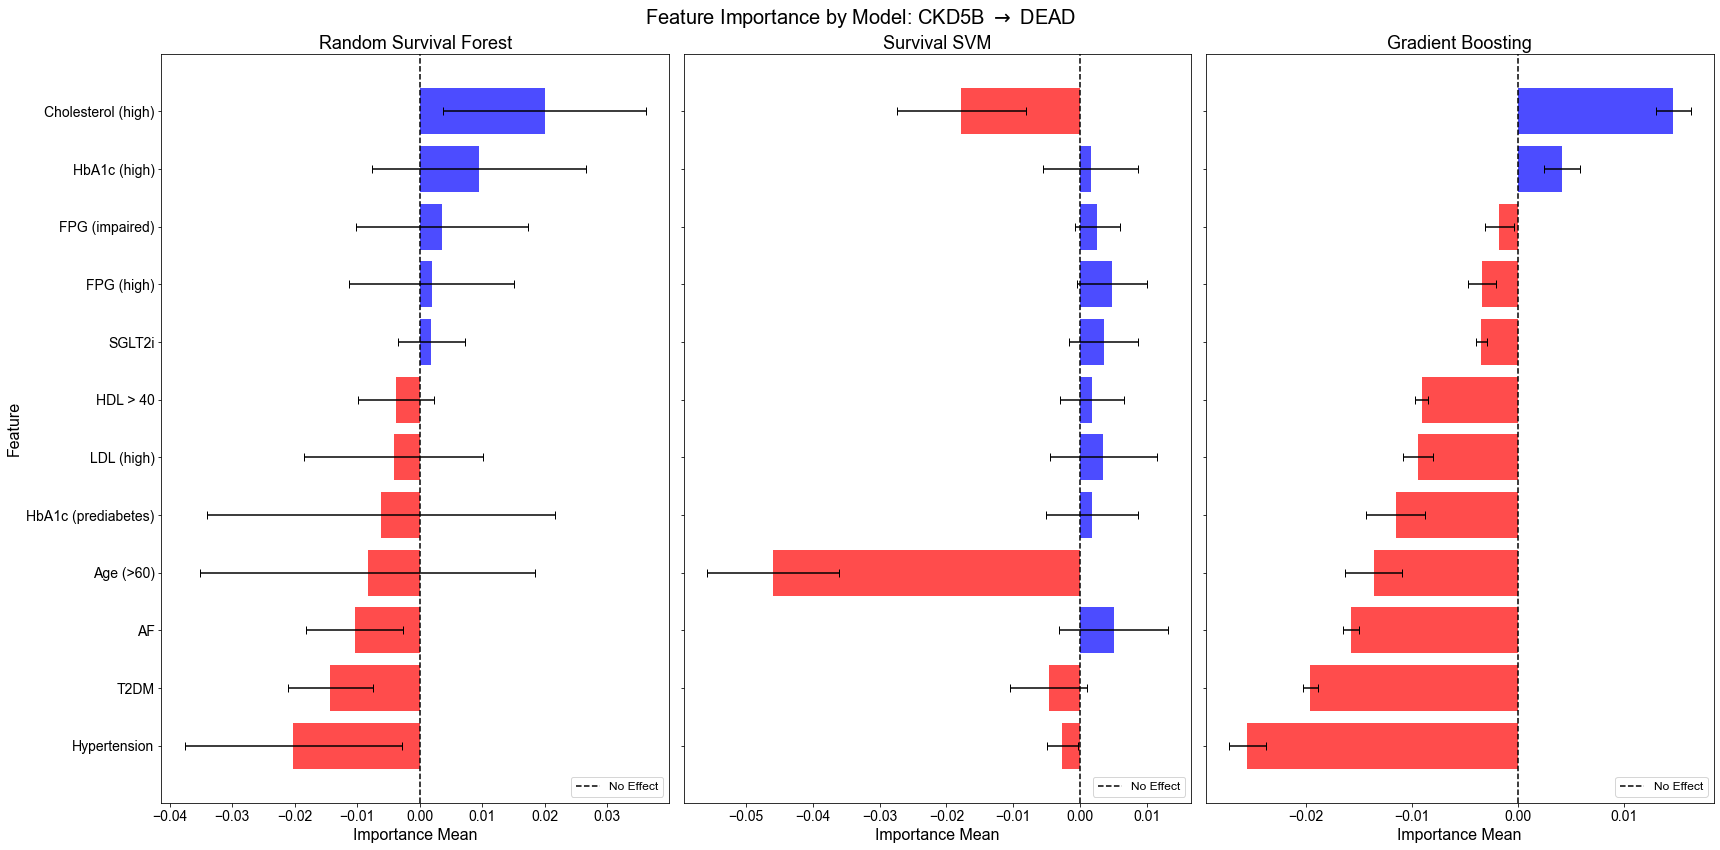

In [109]:
plt.rcParams['font.family'] = 'Arial'

model_names = ['randomsurvivalforest', 'survivalsvm', 'gradientboosting']
model_title_dict = {
    'randomsurvivalforest': 'Random Survival Forest',
    'gradientboosting': 'Gradient Boosting',
    'survivalsvm': 'Survival SVM'
}

# Suppose you define paths for each model:
importance_paths = {
    m: os.path.join(resu_path, f"modeling/{m}/feature_importance/23December2024/")
    for m in model_names}


def read_importance_csv(model_name, transition):
    csv_path = os.path.join(importance_paths[model_name], f"{transition}.csv")
    df = pd.read_csv(csv_path)
    df['lower_bound'] = df['importance_mean'] - df['importance_std']
    df['upper_bound'] = df['importance_mean'] + df['importance_std']
    df['feature'] = df['feature'].map(rename_dict).fillna(df['feature'])
    return df

for transition in unique_transitions:
    model_dfs = {}
    for m in model_names:
        model_dfs[m] = read_importance_csv(m, transition)
    df_rsf = model_dfs['randomsurvivalforest'].copy()
    df_rsf = df_rsf.sort_values('importance_mean', ascending=False)
    all_features_sorted = df_rsf['feature'].tolist()
    fig, axes = plt.subplots(1, 3, figsize=(24, 12), sharey=True)
    plt.subplots_adjust(wspace=0.1)
    for i, m in enumerate(model_names):
        ax = axes[i]
        df_m = model_dfs[m].copy()
        df_m.set_index('feature', inplace=True)
        df_m = df_m.reindex(all_features_sorted)
        imp_means = df_m['importance_mean']
        imp_lower = df_m['importance_mean'] - df_m['lower_bound']
        imp_upper = df_m['upper_bound'] - df_m['importance_mean']
        colors = ['red' if x < 0 else 'blue' for x in imp_means]
        ax.barh(all_features_sorted, imp_means, xerr=[imp_lower, imp_upper],
                color=colors, alpha=0.7, capsize=4)
        ax.axvline(x=0, color='black', linestyle='--', label='No Effect')
        ax.set_title(model_title_dict[m], fontsize=18)
        if i == 0:
            ax.set_ylabel('Feature', fontsize=16)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('Importance Mean', fontsize=16)
        ax.invert_yaxis()
        ax.tick_params(axis='y', labelsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.legend(loc='lower right', fontsize=12)
    formatted_transition = transition.replace('_to_', r' $\rightarrow$ ')
    fig.suptitle(f"Feature Importance by Model: {formatted_transition}", fontsize=20)
    save_path = os.path.join(importance_paths['randomsurvivalforest'], f"plots/combined_{transition}.png")
    plt.tight_layout()
    plt.savefig(save_path, dpi=500, bbox_inches='tight')
    plt.show()

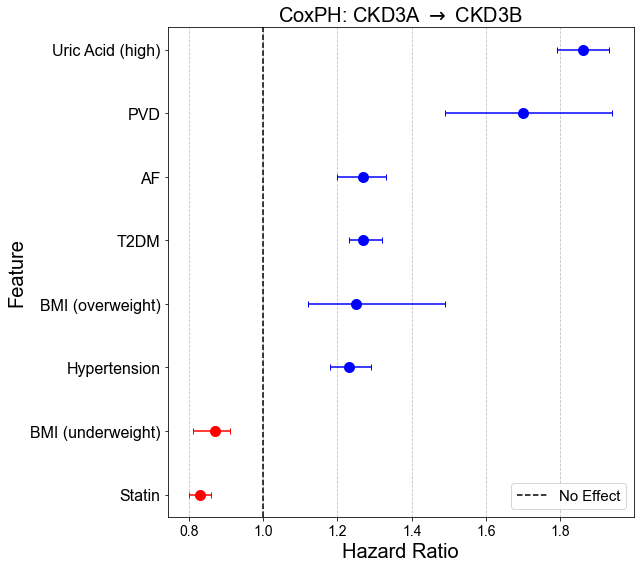

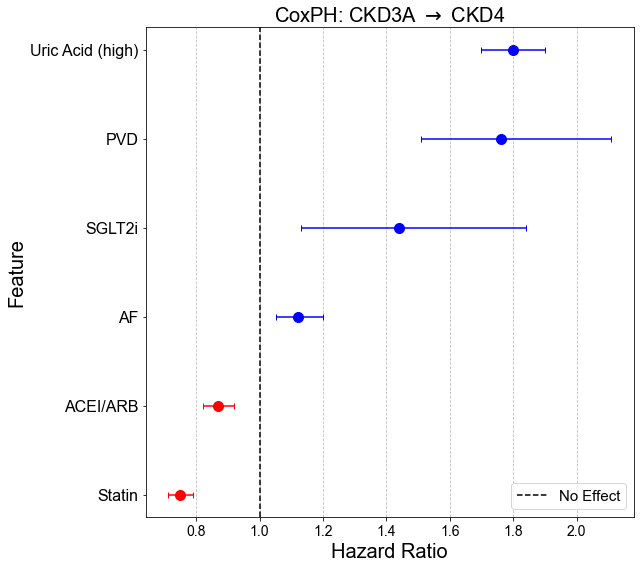

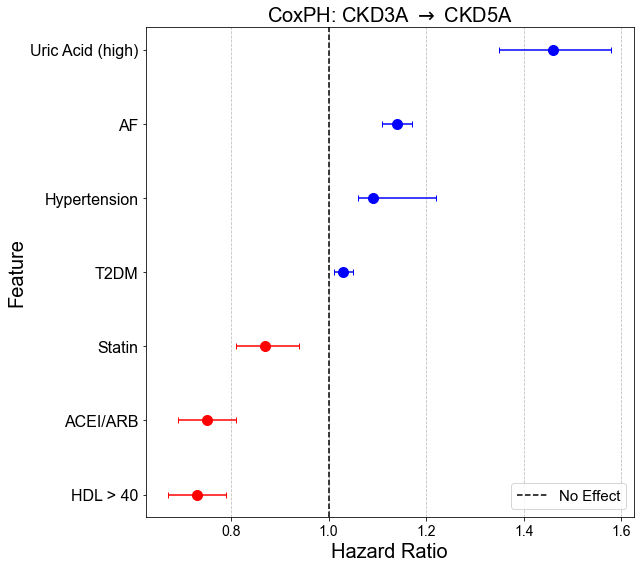

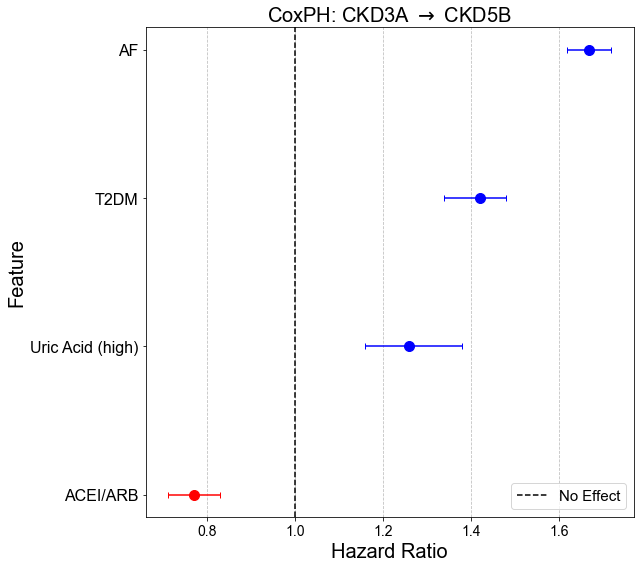

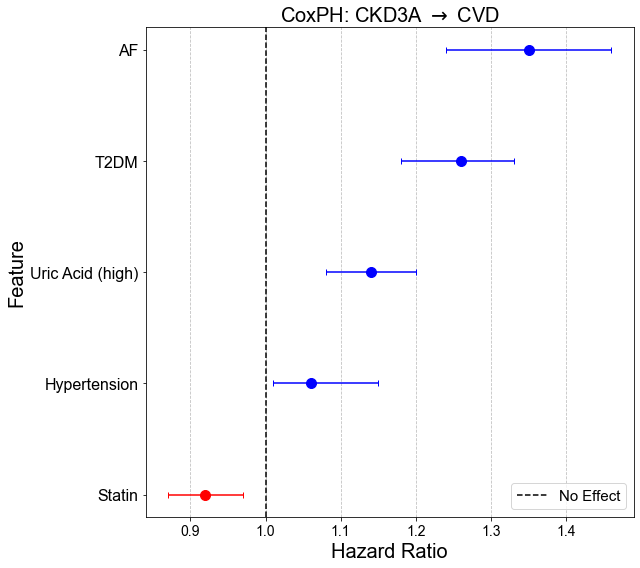

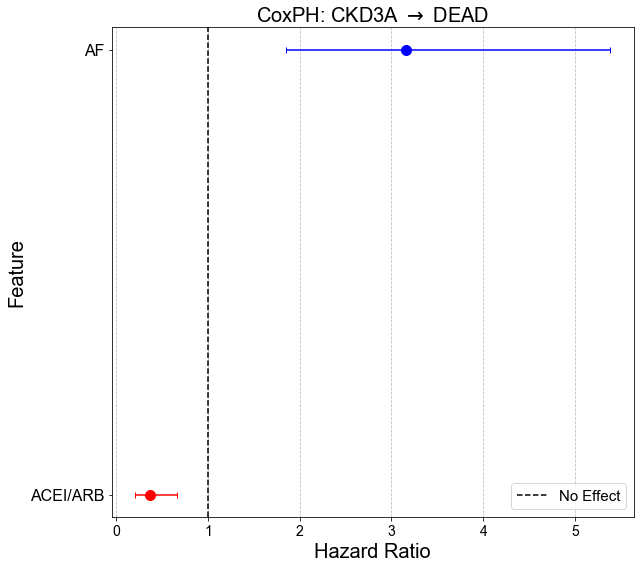

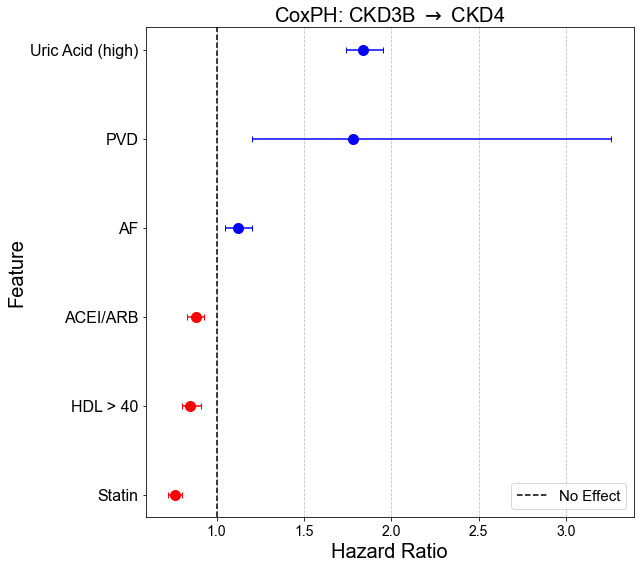

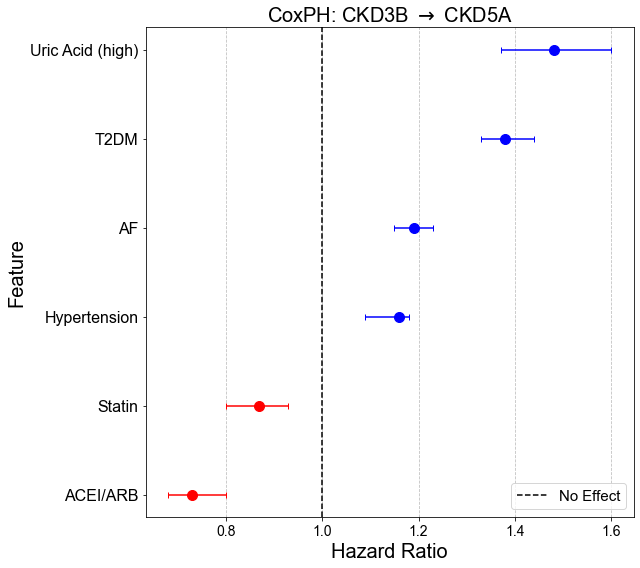

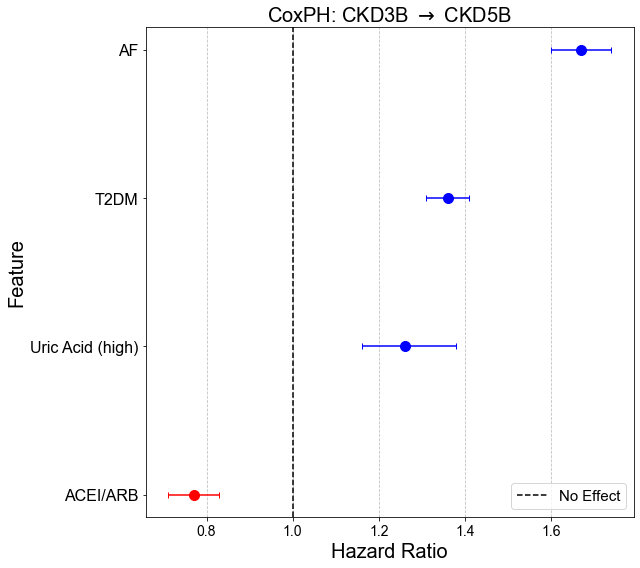

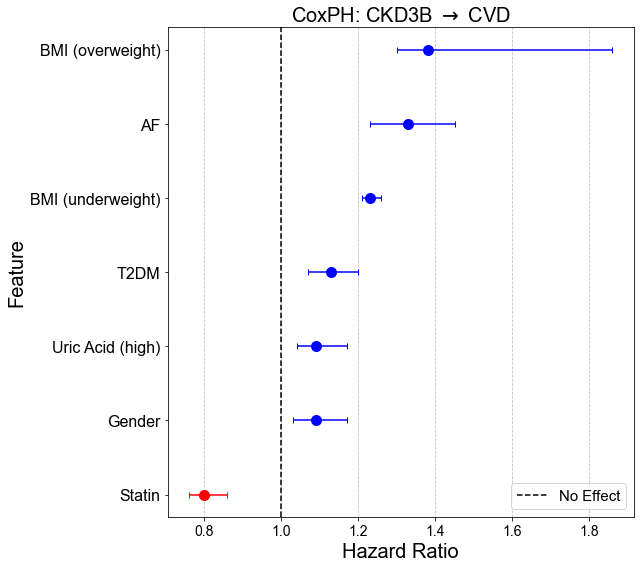

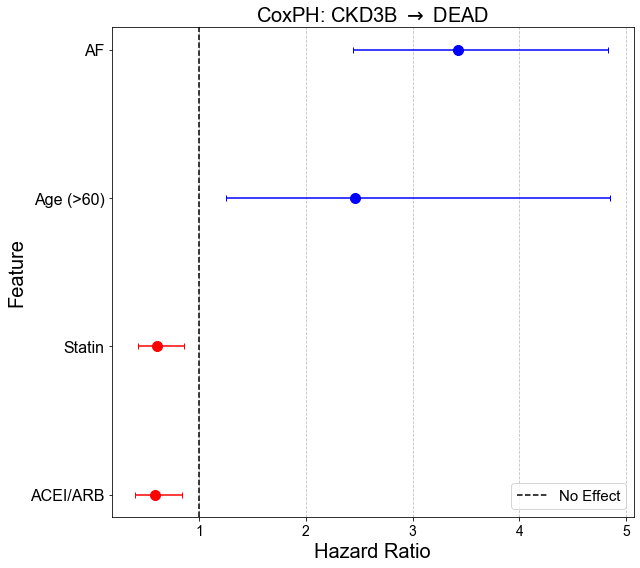

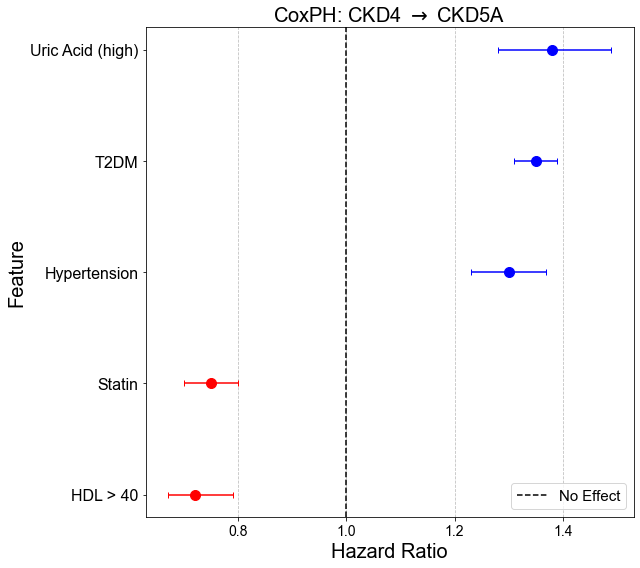

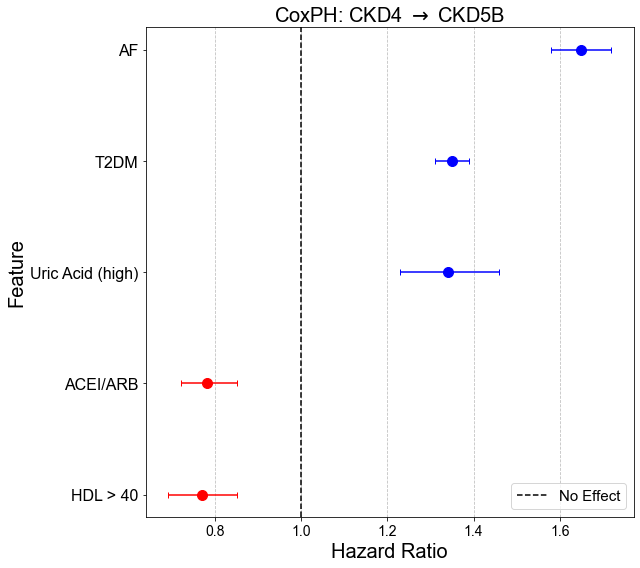

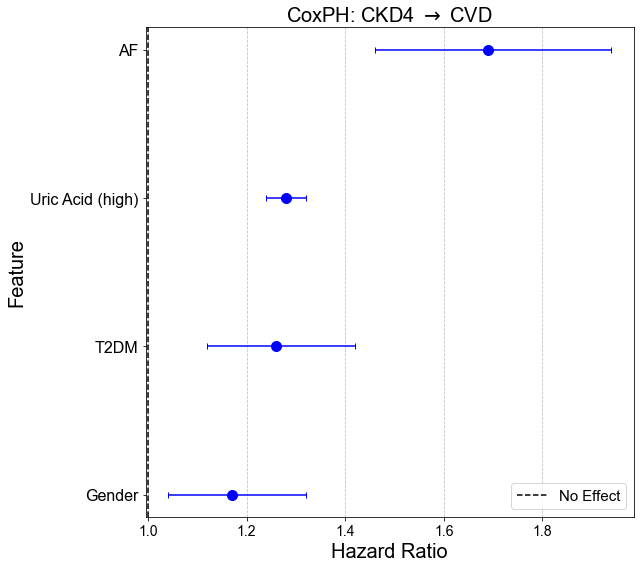

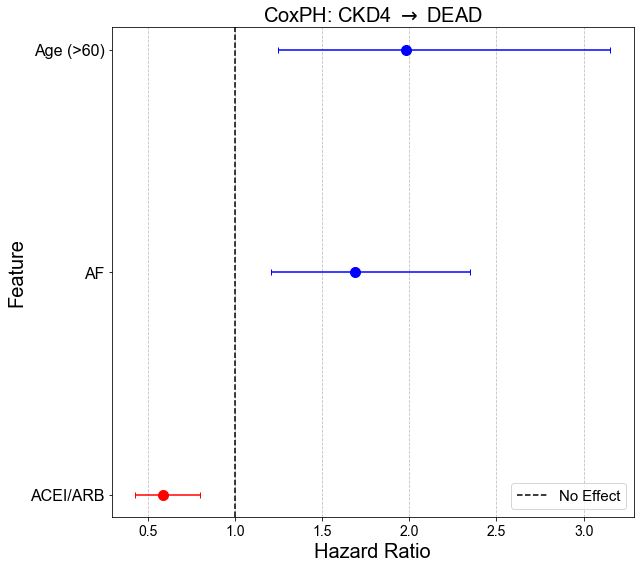

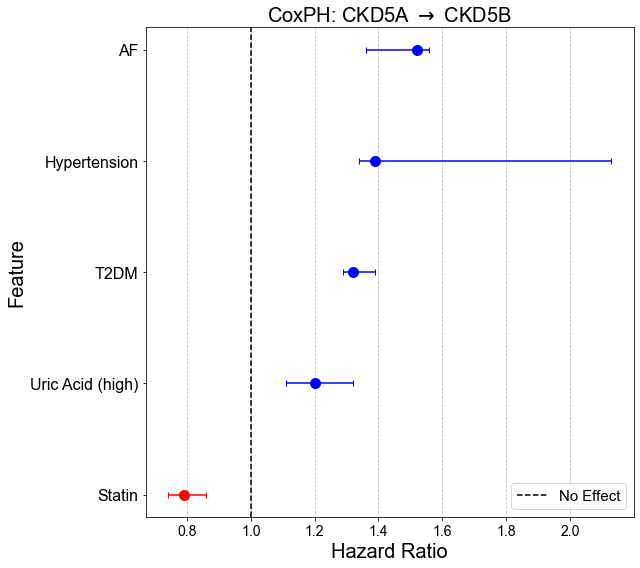

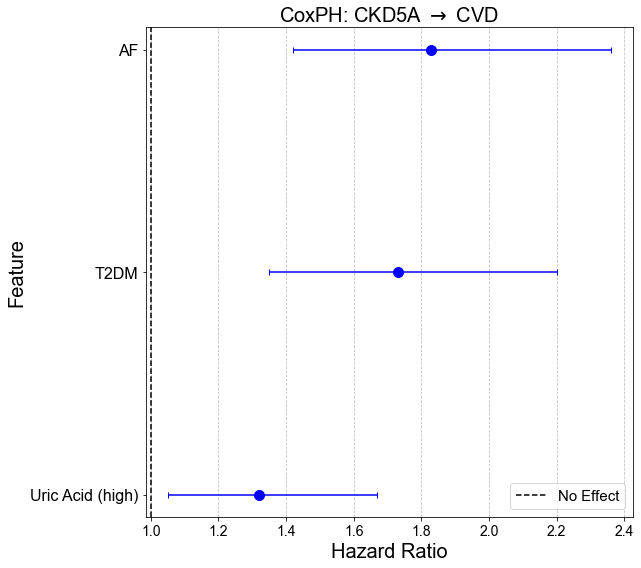

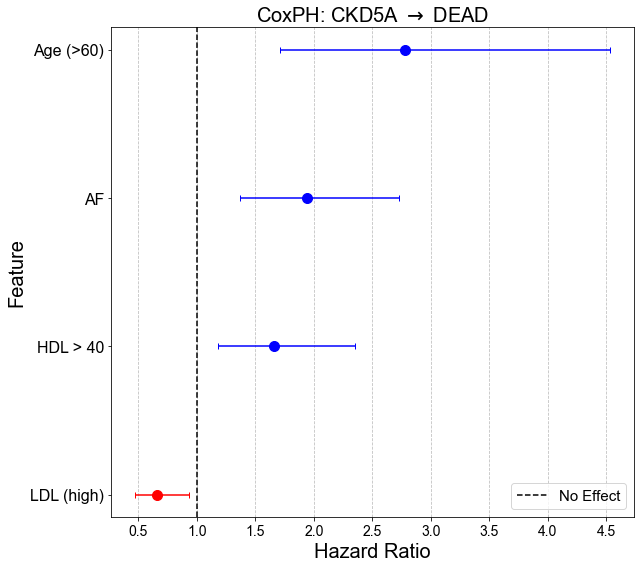

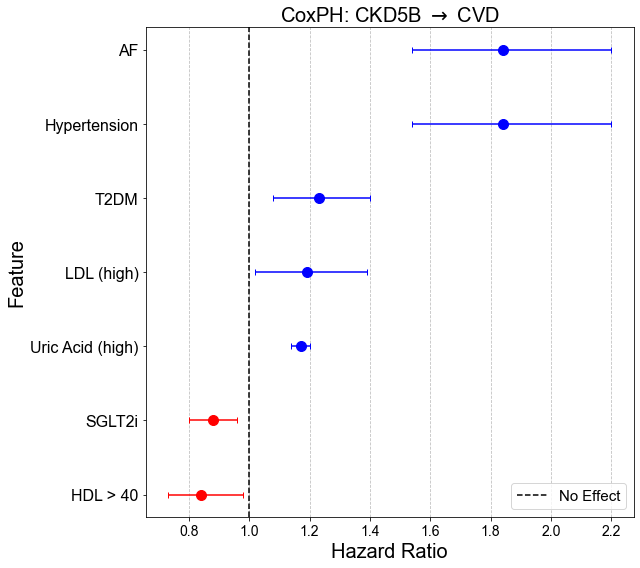

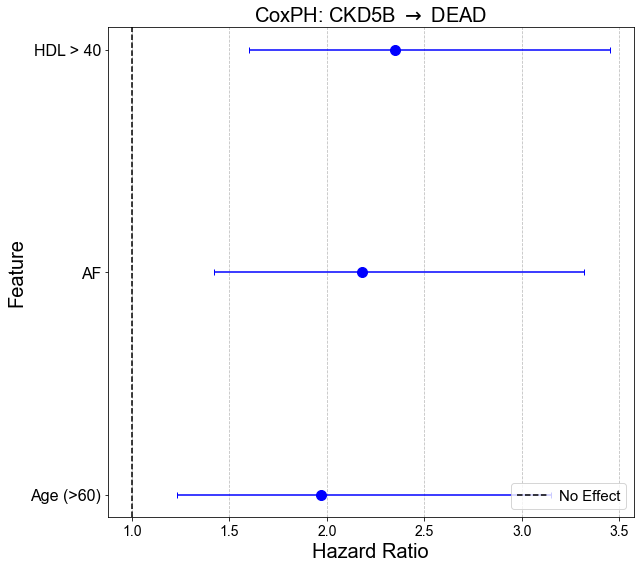

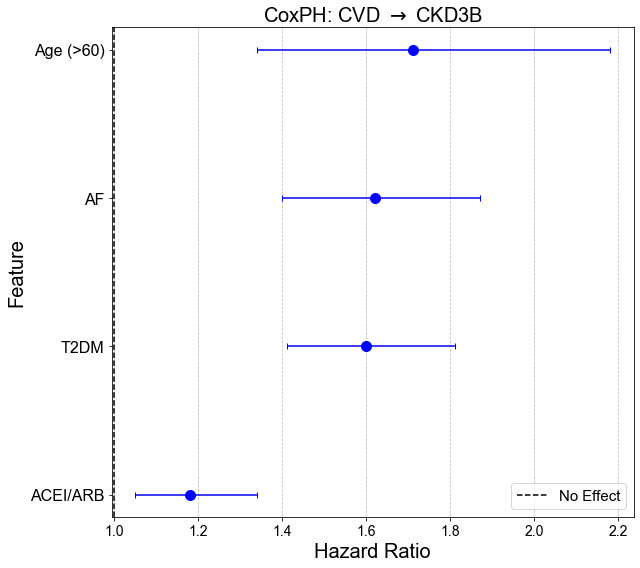

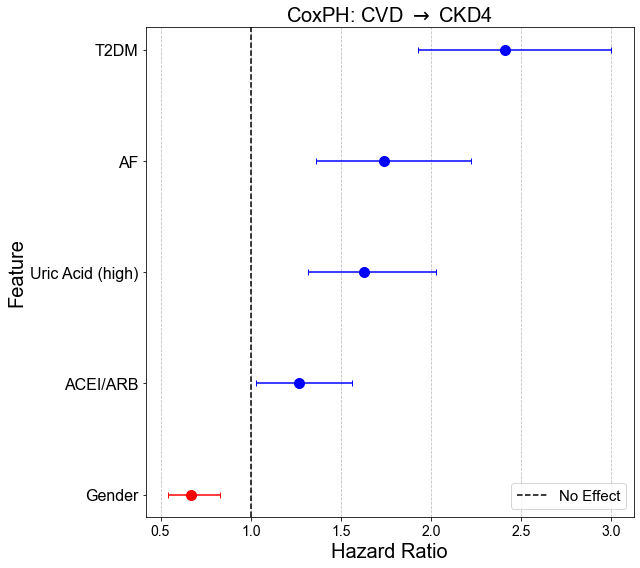

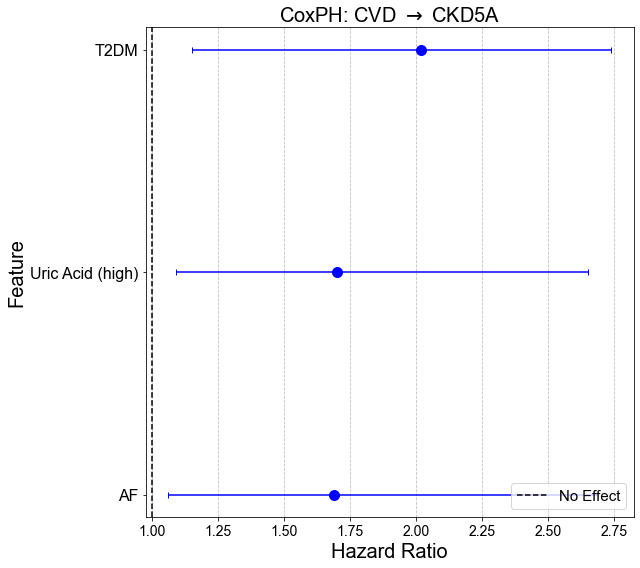

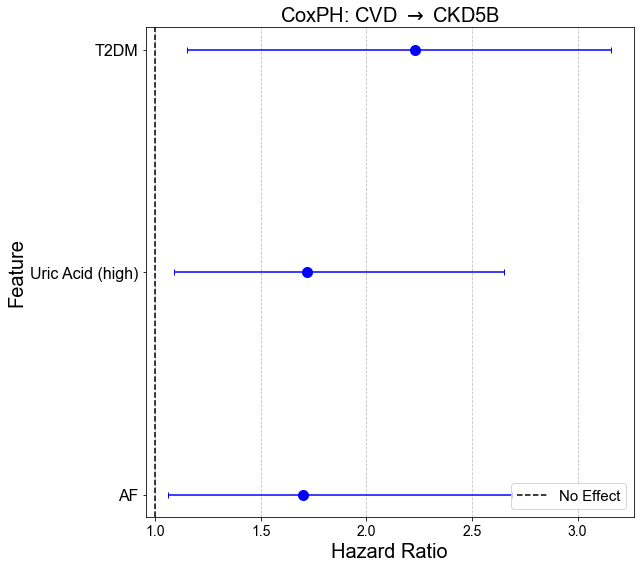

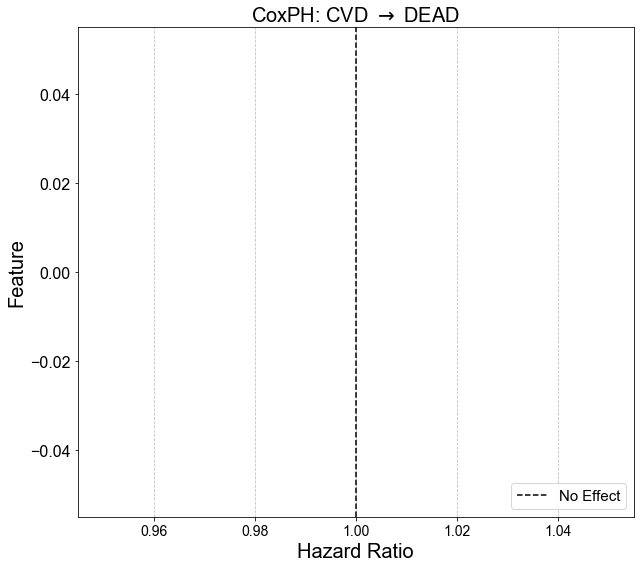

In [41]:
folder_path = r'G:/Shared drives/CKD_Progression/result/univariate/final_21December2024/'
excel_files = [file for file in os.listdir(folder_path) if file.endswith(('.xls', '.xlsx'))]

plt.rcParams['font.family'] = 'Arial'

excel_files = [
    os.path.join(folder_path, file) for file in excel_files 
    if ('CKD' in file or 'CVD' in file or 'DEAD' in file) and not file.startswith('~$')]
excel_files = sorted(excel_files)

for file in excel_files:
    df = pd.read_excel(file, sheet_name='Sheet1').iloc[1:]
    transitions = file.split('/')[-1].split('.')[0]
    formatted_transition = transitions.replace('_to_', r' $\rightarrow$ ')

    df['Unnamed: 12'] = pd.to_numeric(df['Unnamed: 12'], errors='coerce').apply(lambda x: np.round(x, 2) if pd.notnull(x) else x)
    df['HR (95CI)'] = df['Unnamed: 12'].astype(str) + ' ' + df['Unnamed: 13'].fillna('')
    df = df[['Unnamed: 1', 'HR (95CI)', 'Unnamed: 12']]
    df.columns = ['variable', 'HR (95CI)', 'HR']
    df = df[df['HR'].notna()]

    df['lower_bound'] = df['HR (95CI)'].str.extract(r'\(([\d.]+),')[0].astype(float)
    df['upper_bound'] = df['HR (95CI)'].str.extract(r', ([\d.]+)\)')[0].astype(float)
    df['variable'] = df['variable'].map(rename_dict).fillna(df['variable'])
    df = df.sort_values(by = 'HR', ascending = True)
    plt.figure(figsize = (9, 8))

    for index, row in df.iterrows():
        color = 'blue' if row['HR'] > 1 else 'red'
        plt.errorbar(
            row['HR'], 
            row['variable'], 
            xerr = [np.abs([row['HR'] - row['lower_bound']]), np.abs([row['upper_bound'] - row['HR']])], 
            fmt  ='o', 
            markersize = 10,
            color  = color, 
            ecolor = color, 
            elinewidth = 1.5, 
            capsize = 3
        )

    plt.axvline(x = 1, color = 'black', linestyle='--', label = 'No Effect')
    plt.xlabel("Hazard Ratio", fontsize = 20)
    plt.ylabel("Feature", fontsize = 20)
    plt.title(f"CoxPH: {formatted_transition}", fontsize=20)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.grid(axis='x', linestyle = '--', alpha = 0.8)
    plt.legend(loc = 'lower right', fontsize = 15)
    plt.tight_layout()
    plt.show()

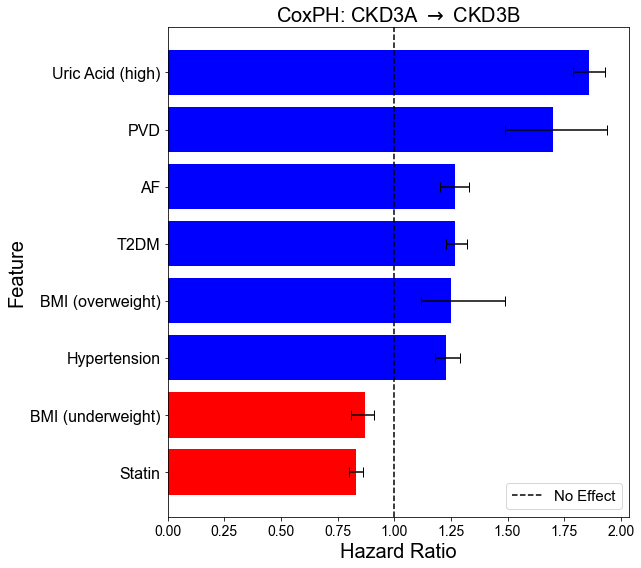

In [12]:
folder_path = r'G:/Shared drives/CKD_Progression/result/univariate/LR_test/'
excel_files = [file for file in os.listdir(folder_path) if file.endswith(('.xls', '.xlsx'))]

plt.rcParams['font.family'] = 'Arial'

excel_files = [
    os.path.join(folder_path, file) for file in excel_files 
    if ('CKD' in file or 'CVD' in file or 'DEAD' in file) and not file.startswith('~$')]
excel_files = sorted(excel_files)

for file in excel_files:
    df = pd.read_excel(file, sheet_name='Sheet1').iloc[1:]
    transitions = file.split('/')[-1].split('.')[0]
    formatted_transition = transitions.replace('_to_', r' $\rightarrow$ ')

    df['Unnamed: 12'] = pd.to_numeric(df['Unnamed: 12'], errors='coerce').apply(lambda x: np.round(x, 2) if pd.notnull(x) else x)
    df['HR (95CI)'] = df['Unnamed: 12'].astype(str) + ' ' + df['Unnamed: 13'].fillna('')
    df = df[['Unnamed: 1', 'HR (95CI)', 'Unnamed: 12']]
    df.columns = ['variable', 'HR (95CI)', 'HR']
    df = df[df['HR'].notna()]

    df['lower_bound'] = df['HR (95CI)'].str.extract(r'\(([\d.]+),')[0].astype(float)
    df['upper_bound'] = df['HR (95CI)'].str.extract(r', ([\d.]+)\)')[0].astype(float)
    df['variable'] = df['variable'].map(rename_dict).fillna(df['variable'])
    df = df.sort_values(by='HR', ascending=True)

    plt.figure(figsize=(9, 8))
    plt.barh(df['variable'], df['HR'], xerr=[df['HR'] - df['lower_bound'], df['upper_bound'] - df['HR']], capsize=5, color=np.where(df['HR'] > 1, 'blue', 'red'))
    plt.axvline(x=1, color='black', linestyle='--', label='No Effect')
    plt.xlabel("Hazard Ratio", fontsize=20)
    plt.ylabel("Feature", fontsize=20)
    plt.title(f"CoxPH: {formatted_transition}", fontsize=20)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=14)
    plt.legend(loc='lower right', fontsize=15)
    plt.tight_layout()
    plt.show()
    break

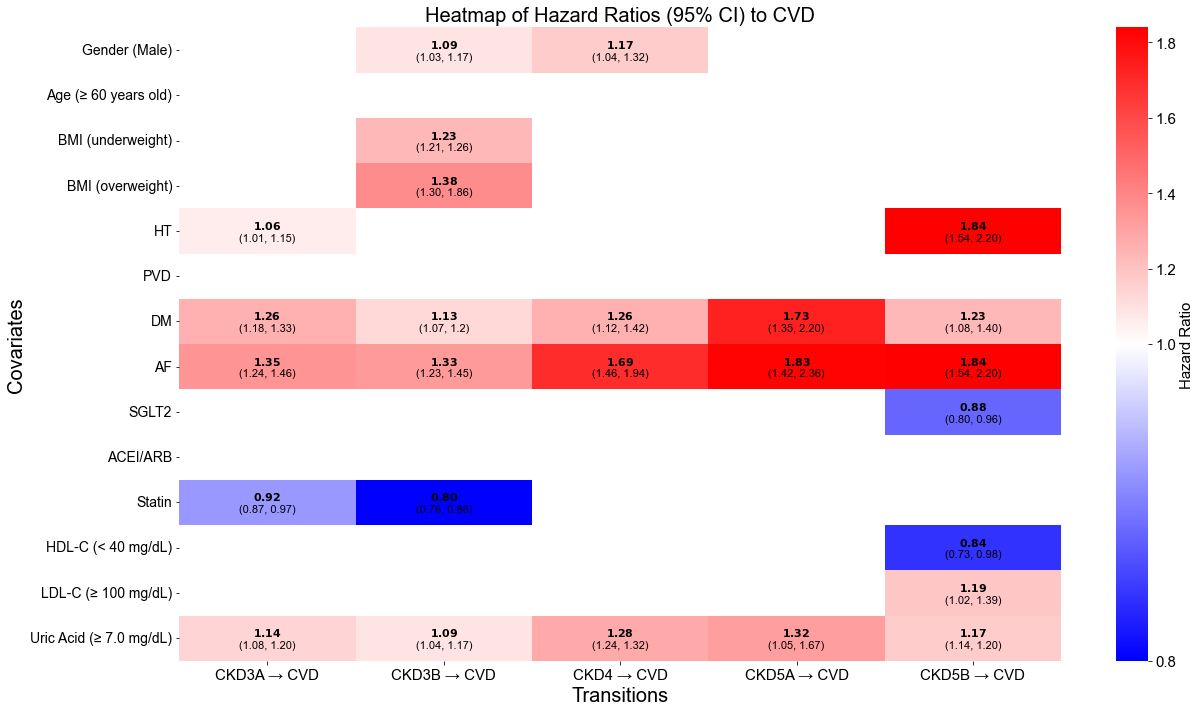

In [129]:
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import re

plt.rcParams['font.family'] = 'Arial'

sheet_name = 'to_CVD'
main_results = pd.read_excel(resu_path + 'multivariate\\main_results_21December2024.xlsx', sheet_name = sheet_name)

transition_columns = main_results.columns.tolist()[2:]
main_results['naming'] = main_results['variable'] + ' (' + main_results['category'] + ')'
main_results.loc[main_results['naming'].isna(), 'naming'] = main_results.loc[main_results['naming'].isna(), 'variable']
main_results = main_results[main_results['naming'] != 'DLP']
for col in transition_columns:
    def extract_value_and_ci(val):
        if isinstance(val, str):
            match = re.match(r'([\d.]+)\s\(([\d.,\s]+)\)', val)
            if match:
                value, ci = match.groups()
                return round(float(value), 3), ci
        return np.nan, np.nan
    
    main_results[[col + '_val', col + '_ci']] = main_results[col].apply(extract_value_and_ci).apply(pd.Series)
    main_results[col] = main_results[col + '_val']

annotations = main_results[transition_columns].copy()
for col in transition_columns:
    annotations[col] = main_results[col].apply(lambda x: f'$\\mathbf{{{x:.2f}}}$' if not pd.isna(x) else '') + \
                       main_results[col + '_ci'].apply(lambda ci: f'\n({ci})' if pd.notna(ci) else '')

main_results.set_index('naming', inplace = True)

custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [
        (0, 'blue'),
        (0.5, 'white'),
        (1, 'red')])

norm = mcolors.TwoSlopeNorm(vmin = main_results[transition_columns].min().min(),
                            vcenter = 1,
                            vmax = main_results[transition_columns].max().max())

plt.figure(figsize = (18, 10))
heatmap = sns.heatmap(main_results[transition_columns], 
                      annot = annotations.values, 
                      fmt = '', 
                      cmap = custom_cmap,
                      norm = norm,
                      linewidths = 0,
                      linecolor = 'black',
                      cbar_kws = {'label': 'Hazard Ratio'},
                      annot_kws = {'color': 'black', 'va': 'center', 'ha': 'center', 'fontsize': 11, 'fontname': 'Arial'})

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('Hazard Ratio', fontsize = 15, fontname = 'Arial')

colorbar.ax.tick_params(labelsize = 15)

plt.xticks(fontsize = 15, color = 'black', fontname = 'Arial')
plt.yticks(fontsize = 14, color = 'black', fontname = 'Arial')
plt.ylabel('Covariates',  fontsize = 20, color = 'black', fontname = 'Arial')
plt.xlabel('Transitions', fontsize = 20, color = 'black', fontname = 'Arial')
plt.title(f'Heatmap of Hazard Ratios (95% CI) {sheet_name.split("_")[0]} {sheet_name.split("_")[1]}', fontsize = 20, color = 'black', fontname = 'Arial')
plt.tight_layout()
plt.show()

In [130]:
main_results = pd.read_csv(resu_path + 'modeling/randomsurvivalforest/rsf_results_log_04December2024.csv')
main_results = main_results[['pathway', 'brier', 'brier_cal', 'ace']]
main_results['brier'] = main_results['brier'] / 3
main_results['brier_cal'] = main_results['brier_cal'] / 5
main_results['ace'] = main_results['ace'] / 5
main_results

,pathway,brier,brier_cal,ace
0,CKD3A_to_CKD3B,0.098361,0.041654,0.021363
1,CKD3A_to_CVD,0.167659,0.011546,0.005798
2,CVD_to_CKD3B,0.194393,0.050358,0.014130
3,CVD_to_CKD4,0.293473,0.054446,0.005764
4,CVD_to_CKD5A,0.346257,0.014046,0.002327
5,CVD_to_CKD5B,0.328926,0.022997,0.000788
6,CVD_to_DEAD,0.297744,0.034304,0.002884
7,CKD3B_to_CKD4,0.102725,0.045700,0.015983
8,CKD3B_to_CVD,0.125710,0.024550,0.014056
9,CKD3B_to_DEAD,0.321822,0.022249,0.001936


In [ ]:
def get_calibration_plot(y_test, calibrated, prediction, pathway, folder_name):
    fraction_of_positives,  mean_predicted_value = calibration_curve(y_test['status'], calibrated, n_bins = 120)
    fraction_of_prediction, mean_predicted_preds = calibration_curve(y_test['status'], prediction, n_bins = 50)
    inner, outer = pathway.split('_')[0], pathway.split('_')[2]
    plt.figure(figsize = (7, 6))
    plt.plot(mean_predicted_value, fraction_of_positives,     marker = 'o', markersize = 8, c = 'r', label = 'Calibrated')
    plt.scatter(mean_predicted_preds, fraction_of_prediction, marker = 'o', s = 64, c = 'b', label = 'Uncalibrated')

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')

    plt.xlabel('Mean Predicted Probability', size = 15)
    plt.ylabel('Fraction of Positives', size = 15)
    plt.title(f'{inner} to {outer} Calibration Plot', size = 18)
    plt.legend()

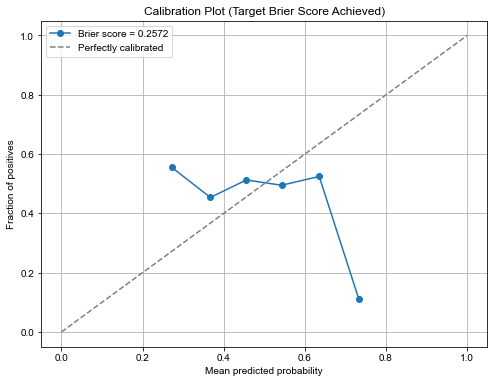

(0.25720214094641697, 10000)

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Set random seed for reproducibility
np.random.seed(42)

# Simulate true labels (50% positive)
y_true = np.random.binomial(1, 0.5, 1000)

# Generate initial predicted probabilities close to 0.5
y_prob = np.random.uniform(0.4, 0.6, size=len(y_true))

# Function to compute Brier score
def compute_brier_score(y_true, y_prob):
    return brier_score_loss(y_true, y_prob)

# Target Brier score
target_brier_score = 0.2323
current_brier_score = compute_brier_score(y_true, y_prob)

# Parameters for the dynamic adjustment
adjustment_factor = 0.05  # Initial adjustment factor (rate of change)
min_adjustment_factor = 0.0001  # Minimum adjustment factor to avoid overshooting
max_iterations = 10000  # Max iterations before stopping

# Iteratively adjust predicted probabilities to match target Brier score
iterations = 0
while np.abs(current_brier_score - target_brier_score) > 0.0001 and iterations < max_iterations:
    # Calculate the error
    error = target_brier_score - current_brier_score
    
    # Dynamically adjust the step size based on the error
    if np.abs(error) < 0.01:  # If we're very close to the target, reduce step size
        adjustment_factor = max(adjustment_factor / 2, min_adjustment_factor)
    
    # Adjust probabilities based on the error and step size
    y_prob += error * adjustment_factor * (np.random.uniform(-1, 1, size=len(y_prob)))
    y_prob = np.clip(y_prob, 0, 1)  # Ensure predictions are within [0, 1]
    
    # Recompute Brier score
    current_brier_score = compute_brier_score(y_true, y_prob)
    iterations += 1

# Print the final Brier score and number of iterations
final_brier_score = current_brier_score
final_iterations = iterations

# Generate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'Brier score = {final_brier_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
plt.title('Calibration Plot (Target Brier Score Achieved)')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.grid(True)
plt.show()

final_brier_score, final_iterations


In [ ]:
len(uncalibrated_scores_adjusted)

21